In [1]:
import project_path

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import sqlite3 as sl
from tqdm import tqdm
from typing import List, Any, Tuple, Dict

from lib.detectors import KS_Detector
from lib.inspector import Inspector
from lib.inspector import OneNightStandInspector
from lib.qmt import execute_programs
from lib.utils import iterate_over
from lib.utils import load_config_and_check

%load_ext autoreload
%autoreload 2

## Utility functions

In [2]:
from copy import deepcopy
from os.path import join
import pathlib
import shutil


In [3]:
from lib.inspector import retrieve_relevant_file_paths
from lib.inspector import read_program
from lib.inspector import create_folder_in_interesting_cases
from lib.inspector import copy_bug
from lib.inspector import normalize_names
from lib.inspector import inspec_column_of
from lib.inspector import scan_log_for

from lib.inspector import get_alarms_with_method
from lib.inspector import count_alarms_with_method
from lib.inspector import get_first_n

## Parameters

In [19]:
EXP_FOLDER = "qmt_v20" 
SQL_PATH = os.path.join("..", "data", EXP_FOLDER, "qfl.db")
LOG_PATH = os.path.join("..", "data", EXP_FOLDER, "log_fuzzy.txt")
SQL_CONNECTION = sl.connect(SQL_PATH)

## Read Data

In [20]:
df_crash = pd.read_sql("""SELECT * from CRASHDATA""", SQL_CONNECTION)
df_data = pd.read_sql("""SELECT * from QFLDATA""", SQL_CONNECTION)
#LOG_CONTENT = open(LOG_PATH, 'r').read()
#LOG_LINES = LOG_CONTENT.split("\n")

In [21]:
print(f"Total (potentially divergent) comparisons: {len(df_data)}")
print(f"Total crash in programs: {len(df_crash)}")
print(f"\tcrashing source: {len(df_crash[~df_crash['exceptions.source'].isna()])}")
print(f"\tcrashing follow-up: {len(df_crash[~df_crash['exceptions.followup'].isna()])}")

Total (potentially divergent) comparisons: 61487
Total crash in programs: 24889
	crashing source: 0
	crashing follow-up: 24889


# Crashes

In [22]:
df_crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24889 entries, 0 to 24888
Data columns (total 42 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   index                                       24889 non-null  int64  
 1   program_id                                  24889 non-null  object 
 2   time_exec                                   24889 non-null  float64
 3   abs_start_time                              24889 non-null  int64  
 4   source.program_id                           24889 non-null  object 
 5   source.selected_gate_set                    24889 non-null  object 
 6   source.selected_optimization                24889 non-null  object 
 7   source.shots                                24889 non-null  int64  
 8   source.n_qubits                             24889 non-null  int64  
 9   source.n_ops                                24889 non-null  int64  
 10  source.opt

In [69]:
from collections import Counter

K = 10
print(f"TOP {K} CRASH MESSAGES (without normalization)")
c = Counter(df_crash["exceptions.followup"])
c.most_common(100)

TOP 10 CRASH MESSAGES (without normalization)


[('"Duplicate declaration for gate \'rzx\' at line 4, file .\\nPrevious occurrence at line 3, file "',
  3633),
 ('"Duplicate declaration for gate \'rzx\' at line 6, file .\\nPrevious occurrence at line 5, file "',
  652),
 ('"Cannot find gate definition for \'rzx\', line 3 file "', 127),
 ('"Duplicate declaration for gate \'rzx\' at line 5, file .\\nPrevious occurrence at line 4, file "',
  48),
 ('"Cannot unroll the circuit to the given basis, [\'ccx\', \'h\']. Instruction id not found in equivalence library and no rule found to expand."',
  37),
 ('"Cannot unroll the circuit to the given basis, [\'rx\', \'ry\', \'rz\', \'p\', \'cx\']. Instruction id not found in equivalence library and no rule found to expand."',
  35),
 ('"Cannot unroll the circuit to the given basis, [\'cx\', \'h\', \'s\', \'t\']. Instruction id not found in equivalence library and no rule found to expand."',
  28),
 ('"Cannot find gate definition for \'c3sx\', line 5 file "', 26),
 ('"Duplicate declaration for ga

Text(0.5, 1.0, 'Crash Messages (Normalized)')

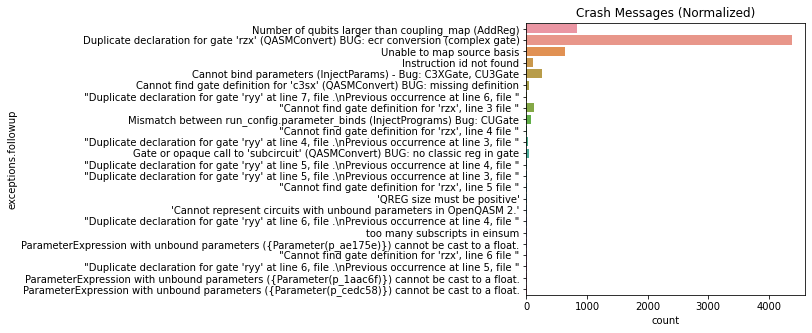

In [70]:
exception_mapping = [
    ["Mismatch between run_config.parameter_binds", "Mismatch between run_config.parameter_binds (InjectPrograms) Bug: CUGate"],
    ["Cannot bind parameters", "Cannot bind parameters (InjectParams) - Bug: C3XGate, CU3Gate"],
    ["greater than maximum", "Number of qubits larger than coupling_map (AddReg)"],
    ["qc is greater than maximum", "Number of qubits larger than coupling_map (AddReg)"],
    ["Unable to map source basis", "Unable to map source basis"],
    ["Instruction id not found", "Instruction id not found"],
    ["Cannot find gate definition for 'c3sx'", "Cannot find gate definition for 'c3sx' (QASMConvert) BUG: missing definition"],
    ["Gate or opaque call to 'subcircuit'", "Gate or opaque call to 'subcircuit' (QASMConvert) BUG: no classic reg in gate"],
    ["Duplicate declaration for gate 'rzx'", "Duplicate declaration for gate 'rzx' (QASMConvert) BUG: ecr conversion (complex gate)"],
]

df_crash_norm = normalize_names(
    df=df_crash, 
    col="exceptions.followup",
    mapping=exception_mapping
)

fig, ax = plt.subplots(figsize=(5,5))

sns.countplot(
    data=df_crash_norm,
    y="exceptions.followup",
    ax=ax
)
ax.set_title("Crash Messages (Normalized)")

In [62]:
df_specific_class = df_crash[df_crash["exceptions.followup"].str.contains("Unable ")]
print(len(df_specific_class))
PROGRAM_ID = df_specific_class.sort_values(by=[
    "source.n_qubits", "source.n_ops"
]).iloc[0]["program_id"]
PROGRAM_ID

8


'b40e833017b34b30a0789a89d385acb4'

# Divergence

In [43]:
PVAL_COL = "divergence.ks.p-value"
ALPHA_LEVEL = 0.05
# df_data.info()

### Divergence: sorted = critical first

In [44]:
TOP_K = 10
df_most_divergent = df_data.sort_values(by=PVAL_COL, ascending=True)
df_most_divergent[["program_id", PVAL_COL]].iloc[:TOP_K].head(TOP_K)

,program_id,divergence.ks.p-value
6720,4c1fb6217e2f4e359a721e68ddc7077e,7.862020e-283
6266,99d5e4fcffaf48acb9d749499c2cd36d,1.143039e-05
3725,2c119d40166048fb85fb4fbdaff80b6b,2.428021e-05
3340,facbe4f34bd540d78f311cd76099dfab,3.158500e-05
7132,fdd8ea57af8e4ff7bd8a5b5831135f2c,1.931279e-04
2604,faa3d51f437c49eda18f7d0a2d83a579,3.487501e-04
842,63f470082a1b46c8b75e5feafeafd073,4.547371e-04
6417,ed9a931731114e7c9238b0a51186e551,5.213968e-04
8519,00e0331823ed49dabd13b37e00f6b2b6,5.500180e-04
1022,92cfe07e1139446bb59876fcdf12270e,6.650153e-04


### Divergence: bonferroni threshold

In [91]:
program_ids_bonferroni = get_alarms_with_method(
    df=df_data, 
    pval_col=PVAL_COL,
    alpha_level=ALPHA_LEVEL,
    method='bonferroni')
program_ids_bonferroni

['4c1fb6217e2f4e359a721e68ddc7077e']

# Inspect Program

In [23]:
PROGRAM_ID = "b40e833017b34b30a0789a89d385acb4"
EXP_FOLDER = "qmt_v20"

In [24]:
BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)
BUG_PATHS

{'source': '../data/qmt_v20/programs/source/b40e833017b34b30a0789a89d385acb4.py',
 'followup': '../data/qmt_v20/programs/followup/b40e833017b34b30a0789a89d385acb4.py',
 'metadata': '../data/qmt_v20/programs/metadata/b40e833017b34b30a0789a89d385acb4.json',
 'metadata_exec': '../data/qmt_v20/programs/metadata_exec/b40e833017b34b30a0789a89d385acb4.json'}

In [25]:
# inspect relevant properties
inspec_column_of(
    df=df_crash, 
    program_id=PROGRAM_ID, 
    target_col="followup.metamorphic_transformations"
)

n hits: 1
['InjectNullEffect', 'ChangeTargetBasis', 'ChangeOptLevel']


In [26]:
print('# SOURCE')
read_program(path=BUG_PATHS['source'], color='red')
print("#" + "-" * 80)
print('# FOLLOWUP')
read_program(path=BUG_PATHS['followup'], color='blue')

# SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_76c59141ed674846b38a2b3fcae19894 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_76c59141ed674846b38a2b3fcae19894, shots=979).result().get_counts(qc)
RESULT = counts
#--------------------------------------------------------------------------------
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRe

## Inspect metadata

In [27]:
import json
with open(BUG_PATHS["metadata"], 'r') as in_file:
    data = json.load(in_file)
    
data['followup']["metamorphic_info"]


{'0': {'n_ops': 8, 'fuzzer_object': 'QiskitFuzzer'},
 '1': {'new_basis_gates': ['cx', 'h', 's', 't']},
 '2': {'initial_level': 2, 'new_level': 0}}

## Rerun programs

In [84]:
RES = execute_programs(
    metadata_source = {"py_file_path": BUG_PATHS["source"]},
    metadata_followup = {"py_file_path": BUG_PATHS["followup"]}
)
RES

Exceptions from execution: {'source': None, 'followup': None}


{'res_A': {'00000': 979},
 'platform_A': 'source',
 'res_B': {'10100': 271, '01000': 237, '11100': 235, '00000': 236},
 'platform_B': 'follow_up',
 'exceptions': {'source': None, 'followup': None},
 'time_exec': 0.3386019398458302}

In [51]:
detector = KS_Detector()
_, pval = detector.check(RES["res_A"], RES["res_B"])
pval

1.0

n_qubits: 5
n_shots_platform_a: 979.0
n_shots_platform_b: 979.0
Uniform threshold: 0.03125


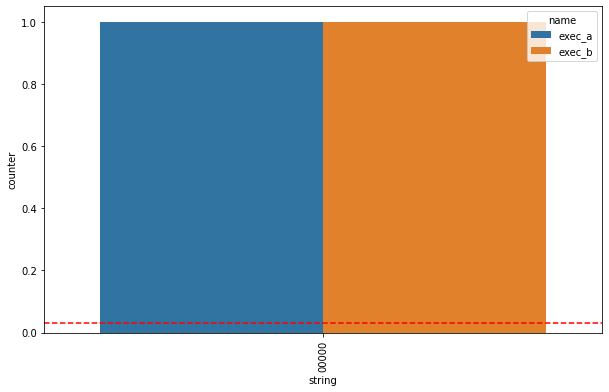

In [53]:
OneNightStandInspector(RES["res_A"], RES["res_B"], top_perc=.25)

# Log scan
check the log for keywords

In [10]:
EXP_FOLDER = "qmt_v07" 
log_path = os.path.join("..", "data", EXP_FOLDER, "log_fuzzy.txt")
log_content = open(log_path, 'r').read()
log_lines = log_content.split("\n")

In [11]:
len(log_lines)

1411086

### Clear crashes

In [30]:
relevant_lines = scan_log_for(
    log_lines=log_lines, 
    target_string="'followup':",
    exclude_string="'followup': None"
)
relevant_lines

[['Applying transformation: change_coupling_map',
  'Follow: coupling map changed:None -> [[0, 1], [0, 3], [1, 0], [1, 2], [2, 1], [3, 0]]',
  'Executing: 702666942a78493cb86c73e446e32ac2 (2022-02-25-18:15:44)',
  'Crash found. Exception:  {\'source\': None, \'followup\': "\'qargs not in this circuit\'"}',
  '1 new divergent programs found.',
  '   index                        program_id  time_exec  ... divergence.ks.time exceptions.source          exceptions.followup'],
 ['Applying transformation: change_coupling_map',
  'Follow: coupling map changed:None -> [[0, 1], [0, 2], [1, 0], [2, 0], [2, 5], [2, 6], [2, 7], [2, 8], [3, 6], [4, 6], [5, 2], [6, 2], [6, 3], [6, 4], [7, 2], [8, 2]]',
  'Executing: d16a9864a4b2409fb2bc35f7aeb803be (2022-02-25-18:15:45)',
  'Crash found. Exception:  {\'source\': None, \'followup\': "\'qargs not in this circuit\'"}',
  '1 new divergent programs found.',
  '   index                        program_id  time_exec  ... divergence.ks.time exceptions.source 

### Divergent Cases

In [31]:
relevant_lines = scan_log_for(log_lines=log_lines, target_string="divergent")

In [33]:
print(len(relevant_lines))
relevant_lines

41741


[['Follow: coupling map changed:None -> [[0, 1], [0, 3], [1, 0], [1, 2], [2, 1], [3, 0]]',
  'Executing: 702666942a78493cb86c73e446e32ac2 (2022-02-25-18:15:44)',
  'Crash found. Exception:  {\'source\': None, \'followup\': "\'qargs not in this circuit\'"}',
  '1 new divergent programs found.',
  '   index                        program_id  time_exec  ... divergence.ks.time exceptions.source          exceptions.followup',
  "0      0  702666942a78493cb86c73e446e32ac2   0.405335  ...           0.011086              None  'qargs not in this circuit'"],
 ['Follow: coupling map changed:None -> [[0, 1], [0, 2], [1, 0], [2, 0], [2, 5], [2, 6], [2, 7], [2, 8], [3, 6], [4, 6], [5, 2], [6, 2], [6, 3], [6, 4], [7, 2], [8, 2]]',
  'Executing: d16a9864a4b2409fb2bc35f7aeb803be (2022-02-25-18:15:45)',
  'Crash found. Exception:  {\'source\': None, \'followup\': "\'qargs not in this circuit\'"}',
  '1 new divergent programs found.',
  '   index                        program_id  time_exec  ... diverge

In [10]:
# qmt_v04 22 Feb 2022 - 21.00
# 55385058d848436999d31be9c0d45387  4.561414e-07 
# 700ae3ec79e747d48df6d0c3a295bf7f  4.640498e-07
# 9fd329b62a4d4f76a82bef40a43e3c41  9.427501e-07
# bf9d01db885a4c65a8e28e5ff4e06ef9  7.748918e-07 
# 9044f1ee448d4f79999afe768e5e7b3f  2.906607e-07
# 4dbd77852fc84c41a515e84a7b0ef8b5  7.049732e-09
# 8ae5d6abf9ee4bb8813aab605e5e036d  8.337349e-07
# 83936da814534c7ba7275030fa389b45  6.009361e-07

In [9]:
log_lines[:20]

['Starting loop... [no timer]',
 'New program couple... [timer: 120 sec]',
 'Executing: f53cc98f2591430887207c1d0bad0ce3',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.21832550182998656 vs threshold: 0.05',
 'i*: 0',
 'New program couple... [timer: 120 sec]',
 'Executing: f3773a633a664e02810b372d000f0937',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.06382648295290216 vs threshold: 0.025',
 'i*: 0',
 'New program couple... [timer: 120 sec]',
 'Executing: 87bd57221135466aa5fbe6d64823225c',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.02698591735714151 vs threshold: 0.016666666666666666',
 'i*: 0',
 'New program couple... [timer: 120 sec]',
 'Executing: 2c78a8718f664594975911795686b986',
 "Crash found. Exception:  {'source': None, 'followup': None}",
 '(i: 1) current p-value: 0.02698591735714151 vs threshold: 0.0125']

# Store an Intesting Case

In [11]:
# copy a given program in the interesting cases folder
EXP_FOLDER = "qmt_v19" 
PROGRAM_ID = "655459b586434ec4b4e2d82f9d6b7abd"

In [12]:
BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)
BUG_PATHS

{'source': '../data/qmt_v19/programs/source/655459b586434ec4b4e2d82f9d6b7abd.py',
 'followup': '../data/qmt_v19/programs/followup/655459b586434ec4b4e2d82f9d6b7abd.py',
 'metadata': '../data/qmt_v19/programs/metadata/655459b586434ec4b4e2d82f9d6b7abd.json',
 'metadata_exec': '../data/qmt_v19/programs/metadata_exec/655459b586434ec4b4e2d82f9d6b7abd.json'}

In [13]:
WARNINGS_FOLDER = "../warnings/program_pairs"
create_folder_in_interesting_cases(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID,
    root_folder=WARNINGS_FOLDER
)

'../warnings/program_pairs/19_655459'

In [14]:
copy_bug(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID,
    root_bug_folder=WARNINGS_FOLDER
)

Copying... from ../data/qmt_v19/programs/source/655459b586434ec4b4e2d82f9d6b7abd.py to ../warnings/program_pairs/19_655459/source_655459b586434ec4b4e2d82f9d6b7abd.py
Copying... from ../data/qmt_v19/programs/followup/655459b586434ec4b4e2d82f9d6b7abd.py to ../warnings/program_pairs/19_655459/followup_655459b586434ec4b4e2d82f9d6b7abd.py
Copying... from ../data/qmt_v19/programs/metadata/655459b586434ec4b4e2d82f9d6b7abd.json to ../warnings/program_pairs/19_655459/metadata_655459b586434ec4b4e2d82f9d6b7abd.json
Copying... from ../data/qmt_v19/programs/metadata_exec/655459b586434ec4b4e2d82f9d6b7abd.json to ../warnings/program_pairs/19_655459/metadata_exec_655459b586434ec4b4e2d82f9d6b7abd.json


# BUGS

## BUG: too many subscripts in einsum [LIMITATION]
https://github.com/Qiskit/qiskit-terra/issues/7700

qmt_v06 948f90de9947418289b220bd2e61caa3

In [34]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
qr = QuantumRegister(11, name='qr')
cr = ClassicalRegister(11, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.x(3)
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.x(3)
qc.draw(fold=-1)

┌──────────────┐     
 qr_0: ┤0             ├─────
       │              │     
 qr_1: ┤1             ├─────
       │              │     
 qr_2: ┤2             ├─────
       │              │┌───┐
 qr_3: ┤3             ├┤ X ├
       │              │└───┘
 qr_4: ┤4             ├─────
       │              │     
 qr_5: ┤5             ├─────
       │              │     
 qr_6: ┤6             ├─────
       │              │     
 qr_7: ┤7             ├─────
       │              │     
 qr_8: ┤8             ├─────
       │              │     
 qr_9: ┤9             ├─────
       │              │     
qr_10: ┤10            ├─────
       │   subcircuit │     
 cr_0: ╡0             ╞═════
       │              │     
 cr_1: ╡1             ╞═════
       │              │     
 cr_2: ╡2             ╞═════
       │              │     
 cr_3: ╡3             ╞═════
       │              │     
 cr_4: ╡4             ╞═════
       │              │     
 cr_5: ╡5             ╞═════
       │              │     
 cr_6: ╡6             ╞═════
       │              │     
 cr_7: ╡7             ╞═════
       │              │     
 cr_8: ╡8             ╞═════
       │              │     
 cr_9: ╡9             ╞═════
       │              │     
cr_10: ╡10            ╞═════
       └──────────────┘

In [37]:
import pdb
pdb.set_trace()
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

--Return--
None
> /tmp/ipykernel_41006/1682671566.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 from qiskit import transpile
      4 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
Breakpoint 21 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
21-> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                         pass

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-p

ipdb> q


BdbQuit: 

In [16]:
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
# fails when (8 continue then 1 step)
# print(current_gate.op); print(prev_gate.op); end
# Instruction(name='p', num_qubits=1, num_clbits=0, params=[1.4169402094934866])
# Instruction(name='subcircuit_dg', num_qubits=11, num_clbits=11, params=[])


# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:137
# genexpr # qarg1 = tuple(qarg[q] for q in node1.qargs)

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:170

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py:451
# _einsum_matmul()

In [14]:
# 11 bits failing
import pdb
pdb.set_trace()
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)


--Return--
None
> /tmp/ipykernel_41006/2811827985.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 from qiskit import transpile
      4 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
Breakpoint 10 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
ipdb> commands 10 
(com) print(current_gate.op); print(prev_gate.op);
(com) end
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
10-> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                   

ipdb> commands 5 
(com) print(current_gate.op); print(prev_gate.op);
(com) end
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
3--> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                         pass

ipdb> print(current_gate.op); print(prev_gate.op);
Instruction(name='p', num_qubits=1, num_clbits=0, params=[1.4169402094934866])
Instruction(name='subcircuit', num_qubits=11, num_clbits=11, params=[])
ipdb> s
--Call--
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(117)_commute()
    115 
    116 
--> 117 def _commute(node1, node2, cache):
    118     if not isinstance(node1, DAGOpNode) or not isinstance(node2, DAGOpNode):

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(244)compose()
    242         new_shape = self._op_shape.compose(other._op_shape, qargs, front)
    243         input_dims = new_shape.dims_r()
--> 244         output_dims = new_shape.dims_l()
    245 
    246         # Full composition of operators

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(247)compose()
    245 
    246         # Full composition of operators
--> 247         if qargs is None:
    248             if front:
    249                 # Composition self * other

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(259)compose()
    257 
    258         # Compose with other on subsystem
--> 259         num_qargs_l, num_qargs_r = self._op_shape.num_qargs
    260         if front:
    261             num_indices = num_qar

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(276)compose()
    274         mat = np.reshape(other.data, other._op_shape.tensor_shape)
    275         indices = [num_indices - 1 - qubit for qubit in qargs]
--> 276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(
    278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(277)compose()
    275         indices = [num_indices - 1 - qubit for qubit in qargs]
    276         final_shape = [np.product(output_dims), np.product(input_dims)]
--> 277         data = np.reshape(
    278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape
    279         )

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ipdb> tensor.shape
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ipdb> final_shape[0]
2048
ipdb> indices
[9, 8, 7, 10, 6, 5, 4, 3, 2, 1, 0]
ipdb> qargs
(1, 2, 3, 0, 4, 5, 6, 7, 8, 9, 10)
ipdb> self._op_shape.tensor_shape
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ipdb> right_mul.shape
*** AttributeError: 'bool' object has no attribute 'shape'
ipdb> right_mul
False
ipdb> shift
0
ipdb> mat.shape
(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
ipdb> mat.ndim
22
ipdb> tensor.ndim
22
ipdb> n
ValueError: too many subscripts in einsum
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(278)compose()
    276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(
--> 278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape
    279         )
    280         ret = Operator(data, input_dims,

BdbQuit: 

In [11]:
# 10 bits WORKING

import pdb
pdb.set_trace()
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)


--Return--
None
> /tmp/ipykernel_41006/2811827985.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 from qiskit import transpile
      4 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
Breakpoint 8 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:77
ipdb> commands
(com) print(current_gate.op); print(prev_gate.op);
(com) end
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(77)run()
     75                     does_commute = False
     76                     try:
8--> 77                         does_commute = _commute(current_gate, prev_gate, self.cache)
     78                     except TranspilerError:
     79                        

ipdb> print(current_gate.op); print(prev_gate.op);
Instruction(name='p', num_qubits=1, num_clbits=0, params=[1.4169402094934866])
Instruction(name='subcircuit', num_qubits=10, num_clbits=10, params=[])
ipdb> s
--Call--
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(117)_commute()
    115 
    116 
--> 117 def _commute(node1, node2, cache):
    118     if not isinstance(node1, DAGOpNode) or not isinstance(node2, DAGOpNode):
    119         return False

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:170
Breakpoint 9 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py:170
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/commutation_analysis.py(170)_commute()
    168            

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(243)compose()
    241         # operator dimensions
    242         new_shape = self._op_shape.compose(other._op_shape, qargs, front)
--> 243         input_dims = new_shape.dims_r()
    244         output_dims = new_shape.dims_l()
    245 

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(244)compose()
    242         new_shape = self._op_shape.compose(other._op_shape, qargs, front)
    243         input_dims = new_shape.dims_r()
--> 244         output_dims = new_shape.dims_l()
    245 
    246         # Full composition of operators

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(247)compose()
    245 
    246         # Full composition of operators
--> 247         if qargs is None:
    248             if front:
    249            

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(275)compose()
    273         tensor = np.reshape(self.data, self._op_shape.tensor_shape)
    274         mat = np.reshape(other.data, other._op_shape.tensor_shape)
--> 275         indices = [num_indices - 1 - qubit for qubit in qargs]
    276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(

ipdb> n
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/quantum_info/operators/operator.py(276)compose()
    274         mat = np.reshape(other.data, other._op_shape.tensor_shape)
    275         indices = [num_indices - 1 - qubit for qubit in qargs]
--> 276         final_shape = [np.product(output_dims), np.product(input_dims)]
    277         data = np.reshape(
    278             Operator._einsum_matmul(tensor, mat, indices, shift, right_mul), final_shape

ipdb> list 276
    271         # qubit 

BdbQuit: 

In [96]:
qr = QuantumRegister(1, name='qr')
cr = ClassicalRegister(1, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(XGate(), qargs=[qr[0]], cargs=[])
qc.append(XGate(), qargs=[qrc[0]], cargs=[])
qc.append(PhaseGate(1.4169402094934866), qargs=[qr[0]], cargs=[])
qc.draw(fold=-1)

┌───┐┌───┐┌───────────┐
  qr: ┤ X ├┤ X ├┤ P(1.4169) ├
      └───┘└───┘└───────────┘
cr: 1/═══════════════════════

In [107]:
%debug

> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/numpy/core/einsumfunc.py(1361)einsum()
   1359         if specified_out:
   1360             kwargs['out'] = out
-> 1361         return c_einsum(*operands, **kwargs)
   1362 
   1363     # Check the kwargs to avoid a more cryptic error later, without having to

ipdb> q


## BUG: HoareOptimization [bug if we want to allow sub-circuit optimizations]
qmt_v05 824c28fef26e41ab8ca656c1068c5799


The hoare optimization (https://arxiv.org/abs/1810.00375) removes the swap if it is swapping identical qubits, such as when it swaps two bits at the start of the circuits when they are both zeros.
Thus Hoare optimization is not suitable for optimizing a subcircuit which STARTS with a SWAP since it will be removed and the entire main cirucuit using it won't have the SWAP gate anymore.

In [125]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(3, name='qr')
cr = ClassicalRegister(3, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')

qc.append(U3Gate(3.1333796742925704,2.0782915724294266,3.8528667493673407), qargs=[qr[0]], cargs=[])

qc.append(SwapGate(), qargs=[qr[0], qr[1]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

qc.decompose().draw(fold=-1)

┌─────────────────────────┐     ┌───┐     ┌─┐   
qr_0: ┤ U(3.1334,2.0783,3.8529) ├──■──┤ X ├──■──┤M├───
      └─────────────────────────┘┌─┴─┐└─┬─┘┌─┴─┐└╥┘┌─┐
qr_1: ───────────────────────────┤ X ├──■──┤ X ├─╫─┤M├
                  ┌─┐            └───┘     └───┘ ║ └╥┘
qr_2: ────────────┤M├────────────────────────────╫──╫─
                  └╥┘                            ║  ║ 
cr: 3/═════════════╩═════════════════════════════╩══╩═
                   2                             0  1

In [126]:
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_98ae9f2e9e3f4728a9fa5a427cf0751b = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_98ae9f2e9e3f4728a9fa5a427cf0751b, shots=489).result().get_counts(qc)
counts_source

{'010': 489}

In [127]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(3, name='qr')
cr = ClassicalRegister(3, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')


qr_0 = QuantumRegister(3, name='qr_0')
cr_0 = ClassicalRegister(3, name='cr_0')
qc_0 = QuantumCircuit(qr_0, cr_0, name='qc_0')

qc_0.append(U3Gate(3.1333796742925704, 2.0782915724294266, 
    3.8528667493673407), qargs=[qr_0[0]], cargs=[])

qr_1 = QuantumRegister(3, name='qr_1')
cr_1 = ClassicalRegister(3, name='cr_1')
qc_1 = QuantumCircuit(qr_1, cr_1, name='qc_1')

qc_1.append(SwapGate(), qargs=[qr_1[0], qr_1[1]], cargs=[])

# OTPION 1: MEASUREMENT IN THE SUBCIRCUIT (WITH OPTIMIZATION): FAIL
# qc_1.measure(qr_1, cr_1)
# passmanager = PassManager()
# passmanager.append(HoareOptimizer(**{'size': 0}))
# qc_1 = passmanager.run(qc_1)

# OPTION 3: LOCAL OPTIMIZATION + MEASUREMENT ADD AFTER TRANSPILATION: FAIL
passmanager = PassManager()
passmanager.append(HoareOptimizer(**{'size': 0}))
qc_1 = passmanager.run(qc_1)


qc.append(qc_0, qargs=qr, cargs=cr)
qc.append(qc_1, qargs=qr, cargs=cr)

# OTPION 2: MEASUREMENT IN THE MAIN CIRCUIT AFTER GLOBAL OPTIMIZATION: WORKS
# qc.measure(qr, cr)
# passmanager = PassManager()
# passmanager.append(HoareOptimizer(**{'size': 0}))
# qc.measure(qr, cr)

qc.decompose().draw(fold=-1)

┌──────────────────────────┐
qr_0: ┤ U3(3.1334,2.0783,3.8529) ├
      └──────────────────────────┘
qr_1: ────────────────────────────
                                  
qr_2: ────────────────────────────
                                  
cr: 3/════════════════════════════

In [128]:
from qiskit import transpile
qc = transpile(qc) #, basis_gates=None, optimization_level=2, coupling_map=None)

# OPTION 3: LOCAL OPTIMIZATION + MEASUREMENT ADD AFTER TRANSPILATION: FAIL
#qc.measure(qr, cr)

from qiskit import Aer, transpile, execute
backend_98ae9f2e9e3f4728a9fa5a427cf0751b = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_98ae9f2e9e3f4728a9fa5a427cf0751b, shots=489).result().get_counts(qc)
counts_follow

{'000': 489}

stat: 1.0, pval: 3.069266633690399e-293
n_qubits: 3
n_shots_platform_a: 489.0
n_shots_platform_b: 489.0
Uniform threshold: 0.125


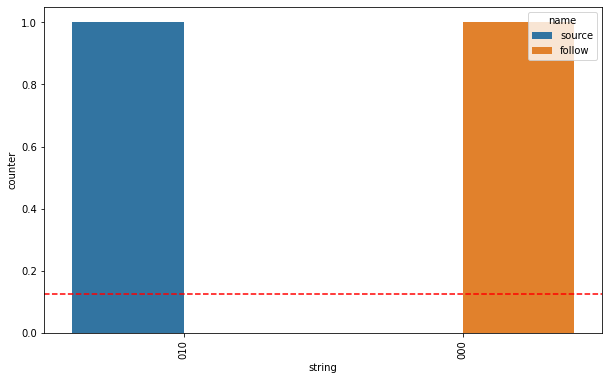

In [129]:
from inspector import OneNightStandInspector
from detectors import KS_Detector, Energy_Detector
detector = KS_Detector()
stat, pval = detector.check(counts_source, counts_follow)
print(f"stat: {stat}, pval: {pval}")
OneNightStandInspector(counts_source, counts_follow, name_a="source", name_b="follow", top_perc=1)

## BUG: GPU Nvidia template
qmt_v01 410155813be54a5287994c1d80c992dd


AER: densitymatrix_thrust.hpp
https://github.com/Qiskit/qiskit-aer/blob/53038b1962894469fcadbcd435e4f31468886f6c/src/simulators/density_matrix/densitymatrix_thrust.hpp
    
CUDA THRUST (CUDA C++ template library): thrust/system/cuda/detail/for_each.h https://github.com/NVIDIA/thrust/blob/a462ff612acfb099e78e35b57644612370969fb0/thrust/system/cuda/detail/for_each.h

OFFICIAL DOC of CUDA C++ template library: https://docs.nvidia.com/cuda/thrust/index.html




In [130]:
EXP_FOLDER = 'qmt_v01'
PROGRAM_ID = '410155813be54a5287994c1d80c992dd'

BUG_PATHS = retrieve_relevant_file_paths(
    experiment_folder=EXP_FOLDER,
    program_id=PROGRAM_ID
)
BUG_PATHS

{'source': '../data/qmt_v01/programs/source/410155813be54a5287994c1d80c992dd.py',
 'followup': '../data/qmt_v01/programs/followup/410155813be54a5287994c1d80c992dd.py',
 'metadata': '../data/qmt_v01/programs/metadata/410155813be54a5287994c1d80c992dd.json',
 'metadata_exec': '../data/qmt_v01/programs/metadata_exec/410155813be54a5287994c1d80c992dd.json'}

In [134]:
for SEED in range(1000):
    program = f"""# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(9, name='qr_qr')
cr_qr = ClassicalRegister(9, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(SXdgGate(), qargs=[qr_qr[7]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[2], qr_qr[6]], cargs=[])
qc.append(iSwapGate(), qargs=[qr_qr[5], qr_qr[4]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, seed_transpiler={SEED})
# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)
# SECTION
# NAME: EXECUTION
from qiskit import Aer, transpile, execute
backend_213141889afb4ac19d274fe469f89af0 = Aer.get_backend(
    'aer_simulator_density_matrix_gpu')
counts = execute(qc, backend=backend_213141889afb4ac19d274fe469f89af0,
    shots=3919).result().get_counts(qc)
RESULT = counts
"""
    print(f'SEED: {SEED}')
    GLOBALS = {"RESULT": 0}
    exec(program, GLOBALS)
    GLOBALS["RESULT"]

SEED: 0
SEED: 1
SEED: 2
SEED: 3
SEED: 4
SEED: 5
SEED: 6
SEED: 7
SEED: 8
SEED: 9
SEED: 10
SEED: 11
SEED: 12
SEED: 13
SEED: 14
SEED: 15
SEED: 16
SEED: 17
SEED: 18
SEED: 19
SEED: 20
SEED: 21
SEED: 22
SEED: 23
SEED: 24
SEED: 25
SEED: 26
SEED: 27
SEED: 28
SEED: 29
SEED: 30
SEED: 31
SEED: 32
SEED: 33
SEED: 34
SEED: 35
SEED: 36
SEED: 37
SEED: 38
SEED: 39
SEED: 40
SEED: 41
SEED: 42
SEED: 43
SEED: 44
SEED: 45
SEED: 46
SEED: 47
SEED: 48
SEED: 49
SEED: 50
SEED: 51
SEED: 52
SEED: 53
SEED: 54
SEED: 55
SEED: 56
SEED: 57
SEED: 58
SEED: 59
SEED: 60
SEED: 61
SEED: 62
SEED: 63
SEED: 64
SEED: 65
SEED: 66
SEED: 67
SEED: 68
SEED: 69
SEED: 70
SEED: 71
SEED: 72
SEED: 73
SEED: 74
SEED: 75
SEED: 76
SEED: 77
SEED: 78
SEED: 79
SEED: 80
SEED: 81
SEED: 82
SEED: 83
SEED: 84
SEED: 85
SEED: 86
SEED: 87
SEED: 88
SEED: 89
SEED: 90
SEED: 91
SEED: 92
SEED: 93
SEED: 94
SEED: 95
SEED: 96
SEED: 97
SEED: 98
SEED: 99
SEED: 100
SEED: 101
SEED: 102
SEED: 103
SEED: 104
SEED: 105
SEED: 106
SEED: 107
SEED: 108
SEED: 109
SEED: 110


SEED: 834
SEED: 835
SEED: 836
SEED: 837
SEED: 838
SEED: 839
SEED: 840
SEED: 841
SEED: 842
SEED: 843
SEED: 844
SEED: 845
SEED: 846
SEED: 847
SEED: 848
SEED: 849
SEED: 850
SEED: 851
SEED: 852
SEED: 853
SEED: 854
SEED: 855
SEED: 856
SEED: 857
SEED: 858
SEED: 859
SEED: 860
SEED: 861
SEED: 862
SEED: 863
SEED: 864
SEED: 865
SEED: 866
SEED: 867
SEED: 868
SEED: 869
SEED: 870
SEED: 871
SEED: 872
SEED: 873
SEED: 874
SEED: 875
SEED: 876
SEED: 877
SEED: 878
SEED: 879
SEED: 880
SEED: 881
SEED: 882
SEED: 883
SEED: 884
SEED: 885
SEED: 886
SEED: 887
SEED: 888
SEED: 889
SEED: 890
SEED: 891
SEED: 892
SEED: 893
SEED: 894
SEED: 895
SEED: 896
SEED: 897
SEED: 898
SEED: 899
SEED: 900
SEED: 901
SEED: 902
SEED: 903
SEED: 904
SEED: 905
SEED: 906
SEED: 907
SEED: 908
SEED: 909
SEED: 910
SEED: 911
SEED: 912
SEED: 913
SEED: 914
SEED: 915
SEED: 916
SEED: 917
SEED: 918
SEED: 919
SEED: 920
SEED: 921
SEED: 922
SEED: 923
SEED: 924
SEED: 925
SEED: 926
SEED: 927
SEED: 928
SEED: 929
SEED: 930
SEED: 931
SEED: 932
SEED: 933


## BUG: Removed final SWAP
qmt_v07 af46c02c1e76475f86caebb03b793f32

In [80]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(10, name='qr')
cr = ClassicalRegister(10, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(1.791678723309873,3.4268190926659594,2.0348474274027337,2.3260376274746286), qargs=[qr[0], qr[5]], cargs=[])
qc.append(YGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(5.414425485082705), qargs=[qr[1]], cargs=[])
qc.append(HGate(), qargs=[qr[2]], cargs=[])
qc.append(CSXGate(), qargs=[qr[8], qr[0]], cargs=[])
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[8]], cargs=[])
qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)

# SECTION
# NAME: MEASUREMENT

qc.draw(fold=-1)

┌────┐   ┌─┐      
 qr_0: ─────────────────────■──────────────────────────────┤ Sx ├───┤M├──────
                            │                ┌─┐           └─┬──┘   └╥┘      
 qr_1: ─────────────────────┼────────────────┤M├─────────────┼───────╫───────
       ┌───┐                │                └╥┘┌───┐        │       ║ ┌─┐   
 qr_2: ┤ H ├────────────────┼─────────────────╫─┤ I ├────────┼───────╫─┤M├───
       └┬─┬┘                │                 ║ └───┘        │       ║ └╥┘   
 qr_3: ─┤M├─────────────────┼─────────────────╫──────────────┼───────╫──╫────
        └╥┘                 │                 ║  ┌─┐         │       ║  ║    
 qr_4: ──╫──────────────────┼─────────────────╫──┤M├─────────┼───────╫──╫────
         ║  ┌───────────────┴───────────────┐ ║  └╥┘         │   ┌─┐ ║  ║    
 qr_5: ──╫──┤ U(1.7917,3.4268,2.0348,2.326) ├─╫───╫──────────┼───┤M├─╫──╫────
         ║  └───────────────────────────────┘ ║   ║     ┌─┐  │   └╥┘ ║  ║    
 qr_6: ──╫────────────────────────────────────╫───╫─────┤M├──┼────╫──╫──╫────
         ║                                    ║   ║  ┌─┐└╥┘  │    ║  ║  ║    
 qr_7: ──╫────────────────────────────────────╫───╫──┤M├─╫───┼────╫──╫──╫────
         ║                ┌───┐               ║   ║  └╥┘ ║   │    ║  ║  ║ ┌─┐
 qr_8: ──╫────────────────┤ Y ├───────────────╫───╫───╫──╫───■────╫──╫──╫─┤M├
         ║                └┬─┬┘               ║   ║   ║  ║        ║  ║  ║ └╥┘
 qr_9: ──╫─────────────────┤M├────────────────╫───╫───╫──╫────────╫──╫──╫──╫─
         ║                 └╥┘                ║   ║   ║  ║        ║  ║  ║  ║ 
cr: 10/══╩══════════════════╩═════════════════╩═══╩═══╩══╩════════╩══╩══╩══╩═
         3                  9                 1   4   7  8        5  0  2  6

In [81]:
from qiskit import Aer, transpile, execute
backend_1159092e1b1b403c94c35df4e3557eaa = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_1159092e1b1b403c94c35df4e3557eaa, shots=5542).result().get_counts(qc)

In [82]:
#FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(10, name='qr')
cr = ClassicalRegister(10, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(1.791678723309873, 3.4268190926659594, 2.0348474274027337, 2.3260376274746286), qargs=[qr[0], qr[5]], cargs=[])
qc.append(YGate(), qargs=[qr[8]], cargs=[])
qc.append(RZGate(5.414425485082705), qargs=[qr[1]], cargs=[])
qc.append(HGate(), qargs=[qr[2]], cargs=[])
qc.append(CSXGate(), qargs=[qr[8], qr[0]], cargs=[])
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[8]], cargs=[])
qc.measure(qr, cr)
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
# SECTION
# NAME: MEASUREMENT

qc.draw(fold=-1)

┌────┐         ┌─┐         
 qr_0: ──────────────────────────────■────────────────────────┤ Sx ├─────────┤M├─────────
       ┌────────────┐                │                        └─┬──┘┌─┐      └╥┘         
 qr_1: ┤ Rz(5.4144) ├────────────────┼──────────────────────────┼───┤M├───────╫──────────
       └───┬───┬────┘                │                ┌───┐     │   └╥┘       ║ ┌─┐      
 qr_2: ────┤ H ├─────────────────────┼────────────────┤ I ├─────┼────╫────────╫─┤M├──────
           └┬─┬┘                     │                └───┘     │    ║        ║ └╥┘      
 qr_3: ─────┤M├──────────────────────┼──────────────────────────┼────╫────────╫──╫───────
            └╥┘                      │                 ┌─┐      │    ║        ║  ║       
 qr_4: ──────╫───────────────────────┼─────────────────┤M├──────┼────╫────────╫──╫───────
             ║       ┌───────────────┴───────────────┐ └╥┘      │    ║ ┌─┐    ║  ║       
 qr_5: ──────╫───────┤ U(1.7917,3.4268,2.0348,2.326) ├──╫───────┼────╫─┤M├────╫──╫───────
             ║       └───────────────────────────────┘  ║       │    ║ └╥┘    ║  ║ ┌─┐   
 qr_6: ──────╫──────────────────────────────────────────╫───────┼────╫──╫──X──╫──╫─┤M├───
             ║                                          ║  ┌─┐  │    ║  ║  │  ║  ║ └╥┘   
 qr_7: ──────╫──────────────────────────────────────────╫──┤M├──┼────╫──╫──┼──╫──╫──╫────
             ║                     ┌───┐                ║  └╥┘  │    ║  ║  │  ║  ║  ║ ┌─┐
 qr_8: ──────╫─────────────────────┤ Y ├────────────────╫───╫───■────╫──╫──X──╫──╫──╫─┤M├
             ║                     └┬─┬┘                ║   ║        ║  ║     ║  ║  ║ └╥┘
 qr_9: ──────╫──────────────────────┤M├─────────────────╫───╫────────╫──╫─────╫──╫──╫──╫─
             ║                      └╥┘                 ║   ║        ║  ║     ║  ║  ║  ║ 
cr: 10/══════╩═══════════════════════╩══════════════════╩═══╩════════╩══╩═════╩══╩══╩══╩═
             3                       9                  4   7        1  5     0  2  6  8

In [83]:
from qiskit import Aer, transpile, execute
backend_1159092e1b1b403c94c35df4e3557eaa = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_1159092e1b1b403c94c35df4e3557eaa, shots=5542).result().get_counts(qc)


stat: 0.009022013713460845, pval: 0.9777867805244991
n_qubits: 10
n_shots_platform_a: 5542.0
n_shots_platform_b: 5542.0
Uniform threshold: 0.0009765625


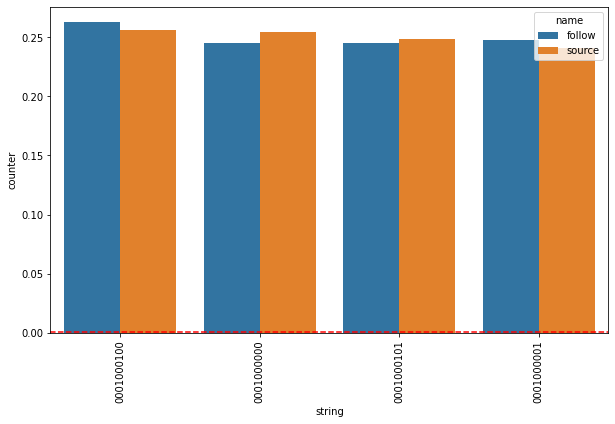

In [84]:
from inspector import OneNightStandInspector
from detectors import KS_Detector, Energy_Detector
detector = KS_Detector()
stat, pval = detector.check(counts_source, counts_follow)
print(f"stat: {stat}, pval: {pval}")
OneNightStandInspector(counts_source, counts_follow, name_a="source", name_b="follow", top_perc=1)

## BUG: divergence [FP: measure after transpile]

qmt_v08 a72f970553aa40f7b7a57f5b111dc5df

In [24]:
relevant_lines = scan_log_for(
    log_lines=LOG_LINES, 
    target_string=PROGRAM_ID, 
    neighborhood=10
)
relevant_lines[0]

['N. applied transformations:  3',
 'Executing: db0d868f104542809fff9ddf5b7d392d (2022-03-04-05:05:51)',
 'Exceptions from execution:  {\'source\': None, \'followup\': "\'qargs not in this circuit\'"}',
 '--------- New programs pair... [timer: 120 sec] (2022-03-04-05:05:51) ----------',
 'Applying: MetamorphicTransformation(ChangeOptLevel)',
 'Follow: optimization level changed: 1 -> 2',
 'Applying: MetamorphicTransformation(ChangeOptLevel)',
 'Follow: optimization level changed: 2 -> 3',
 'Applying: MetamorphicTransformation(InjectNullEffect)',
 'N. applied transformations:  3',
 'Executing: a72f970553aa40f7b7a57f5b111dc5df (2022-03-04-05:05:51)',
 "Exceptions from execution:  {'source': None, 'followup': None}",
 'i*: 4',
 '1 new divergent programs found.',
 '     index                        program_id  time_exec  abs_start_time  ... divergence.ks.p-value divergence.ks.time exceptions.source  exceptions.followup',
 '990      0  a72f970553aa40f7b7a57f5b111dc5df   1.144631      164636

### SOURCE

In [40]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT


qr_random = ClassicalRegister(7, name='qr_random')

qr = QuantumRegister(7, name='qr')
cr = ClassicalRegister(7, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(RXXGate(3.797034706671222), qargs=[qr[0], qr[2]], cargs=[])
qc.append(XGate(), qargs=[qr[5]], cargs=[])
qc.append(CRZGate(0.22156210448240338), qargs=[qr[1], qr[3]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[5]], cargs=[])
qc.append(CZGate(), qargs=[qr[5], qr[3]], cargs=[])
qc.append(CHGate(), qargs=[qr[2], qr[3]], cargs=[])
qc.append(RXXGate(1.803622773685872), qargs=[qr[1], qr[5]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[2]], cargs=[])
qc.append(XGate(), qargs=[qr[5]], cargs=[])
qc.append(RYGate(3.7445241321722085), qargs=[qr[5]], cargs=[])
qc.add_register(qr_random)
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=1, coupling_map=None)
qc.draw(fold=-1)

┌─────────────┐                                                                
       qr_0: ┤0            ├────────────────────────────────────────────────────────────────
             │             │                          ┌──────────────┐                      
       qr_1: ┤  Rxx(3.797) ├───────■──────────────────┤0             ├──────────────────────
             │             │       │                  │              │                      
       qr_2: ┤1            ├───────┼──────────────────┤              ├──■───X───────────────
             └─────────────┘┌──────┴──────┐           │              │┌─┴─┐ │               
       qr_3: ───────────────┤ Rz(0.22156) ├─────────■─┤  Rxx(1.8036) ├┤ H ├─┼───────────────
                            └─────────────┘         │ │              │└───┘ │               
       qr_4: ───────────────────────────────────────┼─┤              ├──────┼───────────────
                                 ┌───┐     ┌──────┐ │ │              │┌───┐ │ ┌────────────┐
       qr_5: ────────────────────┤ X ├─────┤ √Xdg ├─■─┤1             ├┤ X ├─┼─┤ Ry(3.7445) ├
                                 └───┘     └──────┘   └──────────────┘└───┘ │ └────────────┘
       qr_6: ───────────────────────────────────────────────────────────────X───────────────
                                                                                            
       cr: 7/═══════════════════════════════════════════════════════════════════════════════
                                                                                            
qr_random: 7/═══════════════════════════════════════════════════════════════════════════════

In [41]:
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_4b5f412aa10640ecb4fc70459be3accb = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_4b5f412aa10640ecb4fc70459be3accb, shots=1959).result().get_counts(qc)


### FOLLOW

In [42]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(7, name='qr')
cr = ClassicalRegister(7, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(RXXGate(3.797034706671222), qargs=[qr[0], qr[2]], cargs=[])
qc.append(XGate(), qargs=[qr[5]], cargs=[])
qc.append(CRZGate(0.22156210448240338), qargs=[qr[1], qr[3]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[5]], cargs=[])
qc.append(CZGate(), qargs=[qr[5], qr[3]], cargs=[])


subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(RXXGate(0.33451319283313735), qargs=[qr[1], qr[4]], cargs=[])
subcircuit.append(C4XGate(), qargs=[qr[5], qr[1], qr[0], qr[2], qr[3]], cargs=[])
subcircuit.append(SdgGate(), qargs=[qr[6]], cargs=[])
subcircuit.append(PhaseGate(0.9684195693445009), qargs=[qr[6]], cargs=[])
subcircuit.append(C4XGate(), qargs=[qr[5], qr[1], qr[4], qr[0], qr[6]], cargs=[])

qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
qc.append(CHGate(), qargs=[qr[2], qr[3]], cargs=[])
qc.append(RXXGate(1.803622773685872), qargs=[qr[1], qr[5]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[2]], cargs=[])
qc.append(XGate(), qargs=[qr[5]], cargs=[])
qc.append(RYGate(3.7445241321722085), qargs=[qr[5]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL

qc.measure(qr, cr)
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)
qc.draw(fold=-1)

┌─────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                  ┌───┐           ┌───┐          ┌───┐           ┌───┐                              ┌─────────┐┌─────────┐┌───┐┌──────────┐┌─────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌─────────┐┌─────────┐┌───┐┌──────────┐┌─────────┐           ┌───────────┐┌─────────┐┌───┐┌──────────┐┌───────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌───────────┐┌─────────┐┌───┐┌──────────┐┌───────────┐                                                                                  ┌─────────┐┌─────────┐┌───┐┌──────────┐┌─────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌─────────┐┌─────────┐┌───┐┌──────────┐┌─────────┐           ┌───────────┐┌─────────┐┌───┐┌──────────┐┌───────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌───────────┐┌─────────┐┌───┐┌──────────┐┌───────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                    ┌───┐           ┌───┐          ┌───┐                             ┌───┐                               ┌─┐                          
qr_0: ┤0            ├────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────┤ X ├─■─────────┤ X ├─■────────┤ X ├─■─────────┤ X ├─■───────────────────■────────┤ U2(0,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(0,π) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(0,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(0,π) ├─■─────────┤ U2(-2π,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(-2π,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U2(-2π,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(-2π,π) ├─────────────────────────────────────────────────────────────────────────■────────┤ U2(0,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(0,π) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(0,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(0,π) ├─■─────────┤ U2(-2π,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(-2π,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U2(-2π,π) ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ U2(-2π,π) ├────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────────────────┤ X ├─■─────────┤ X ├─■────────┤ X ├─■───────────────────────────┤ X ├─■─────────────────────────────┤M├──────────────────────────
      │             │               ┌───────────────┐                                            │                                                                                                                   │                                                

In [43]:
# SECTION
# NAME: MEASUREMENT

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_4b5f412aa10640ecb4fc70459be3accb = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_4b5f412aa10640ecb4fc70459be3accb, shots=1959).result().get_counts(qc)

In [45]:
counts_source

{'0000000 1100001': 161,
 '0000000 1101001': 197,
 '0000000 1101011': 259,
 '0000000 1000001': 179,
 '0000000 0000010': 51,
 '0000000 0000000': 44,
 '0000000 0100010': 81,
 '0000000 0100000': 35,
 '0000000 1001011': 270,
 '0000000 1100011': 225,
 '0000000 1001001': 183,
 '0000000 1000011': 274}

### Run modified

stat: 0.9765186319550792, pval: 0.0
n_qubits: 7
n_shots_platform_a: 1959.0
n_shots_platform_b: 1959.0
Uniform threshold: 0.0078125


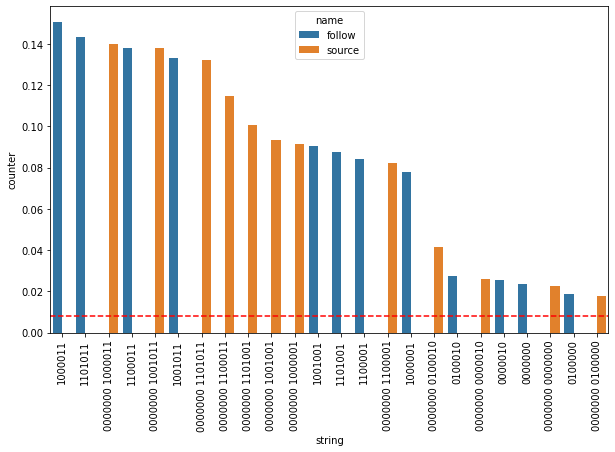

In [44]:
detector = KS_Detector()
stat, pval = detector.check(counts_source, counts_follow)
print(f"stat: {stat}, pval: {pval}")
OneNightStandInspector(counts_source, counts_follow, name_a="source", name_b="follow", top_perc=1)

## BUG: C3XGate and parameters

qmt_v09 462576d5c97842feb25cd7a79d659969

In [158]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

a = Parameter('a')

qr = QuantumRegister(4)
cr = ClassicalRegister(4)
qc = QuantumCircuit(qr, cr)
qc.append(C3XGate(angle=a), qargs=[qr[0], qr[1], qr[2], qr[3]], cargs=[])

qc.measure(qr, cr)
qc.draw(fold=-1)

┌─┐         
qr_0: ──■───┤M├─────────
        │   └╥┘┌─┐      
qr_1: ──■────╫─┤M├──────
        │    ║ └╥┘┌─┐   
qr_2: ──■────╫──╫─┤M├───
      ┌─┴──┐ ║  ║ └╥┘┌─┐
qr_3: ┤ Sx ├─╫──╫──╫─┤M├
      └────┘ ║  ║  ║ └╥┘
cr: 4/═══════╩══╩══╩══╩═
             0  1  2  3

In [156]:
qc = qc.bind_parameters({
    a: 0.1
})

CircuitError: 'Cannot bind parameters (a) not present in the circuit.'

In [7]:
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_7e67d8ab8ef944f9ba7f1e056f79a182 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_7e67d8ab8ef944f9ba7f1e056f79a182, shots=2771).result().get_counts(qc)
counts

CircuitError: 'Cannot bind parameters (p_ead18a) not present in the circuit.'

### Explaination
the angle is set, C3XGate becomes C3SXGate


but in C3SXGate:

```python
if angle is not None:
    warnings.warn(
        "The angle argument is deprecated as of Qiskit Terra 0.17.0 and will "
        "be removed no earlier than 3 months after the release date.",
```

## BUG: CUGate and parameters

qmt_v09 f8a306d8953f4e46a2b8ecec434f9cc0

In [1]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
from math import pi

a = Parameter('a')

qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
#qc.append(RXGate(a), qargs=[qr[0]], cargs=[])
qc.append(CUGate(a, pi, pi, pi), qargs=[qr[0], qr[1]], cargs=[])
qc.measure(qr, cr)
qc.draw(fold=-1)

┌─┐   
qr_0: ──────■───────┤M├───
      ┌─────┴──────┐└╥┘┌─┐
qr_1: ┤ U(a,π,π,π) ├─╫─┤M├
      └────────────┘ ║ └╥┘
cr: 2/═══════════════╩══╩═
                     0  1

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.19.1', 'qiskit-aer': '0.9.1', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.2', 'qiskit-aqua': '0.9.5', 'qiskit': '0.33.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [3]:
#import pdb 
#pdb.set_trace()
qc_concrete = qc.bind_parameters({
    a: pi, 
})

In [ ]:
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:2542

In [4]:
from qiskit import BasicAer, transpile, execute
backend = BasicAer.get_backend('qasm_simulator')

qc_transpiled = transpile(qc_concrete, backend)
qc_transpiled.draw(fold=-1)

┌─┐   
qr_0: ──■───────────────────────■─────────────────┤M├───
      ┌─┴─┐┌─────────────────┐┌─┴─┐┌─────────────┐└╥┘┌─┐
qr_1: ┤ X ├┤ U3(-0.5*a,0,-π) ├┤ X ├┤ U3(a/2,π,0) ├─╫─┤M├
      └───┘└─────────────────┘└───┘└─────────────┘ ║ └╥┘
cr: 2/═════════════════════════════════════════════╩══╩═
                                                   0  1

In [5]:
#import pdb 
#pdb.set_trace()

job = backend.run(qc_transpiled)
counts = job.result().get_counts()
counts

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(a)])]'

In [ ]:
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/providers/basicaer/qasm_simulator.py:409

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/compiler/assembler.py:192



## BUG: Duplicate declaration for gate \'rzx\
qmt_v11 74343b53af17413d86dbdf57b8f6da86

In [187]:
import qiskit
from qiskit import QuantumRegister
from qiskit import Aer, transpile, execute
qc = QuantumCircuit(2, 2, name='qc')
qc.rzx(0.78, 0, 1)
qc.rzx(-0.78, 0, 1)
#qc.ecr(0, 1)
qc.measure_all()
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
import pdb
pdb.set_trace()
print(qc._data)
qc.qasm(formatted=True)

--Return--
None
> /tmp/ipykernel_35760/1038969683.py(11)<module>()
      9 qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
     10 import pdb
---> 11 pdb.set_trace()
     12 print(qc._data)
     13 qc.qasm(formatted=True)

ipdb> c
[(Instruction(name='rzx', num_qubits=2, num_clbits=0, params=[0.78]), [Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)], []), (Instruction(name='rzx', num_qubits=2, num_clbits=0, params=[-0.78]), [Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)], []), (Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)], []), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(2, 'q'), 0)], [Clbit(ClassicalRegister(2, 'meas'), 0)]), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(2, 'q'), 1)], [Clbit(ClassicalRegister(2, 'meas'), 1)])]
O

In [190]:
import qiskit
from qiskit import QuantumRegister
from qiskit import Aer, transpile, execute
qc = QuantumCircuit(2, 2, name='qc')
#qc.rzx(0.78, 0, 1)
#qc.rzx(-0.78, 0, 1)
qc.ecr(0, 1)
qc.measure_all()
#qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
import pdb
pdb.set_trace()
print(qc._data)
qc.qasm(formatted=True)

--Return--
None
> /tmp/ipykernel_35760/3817149345.py(11)<module>()
      9 #qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
     10 import pdb
---> 11 pdb.set_trace()
     12 print(qc._data)
     13 qc.qasm(formatted=True)

ipdb> c
[(Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)], []), (Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)], []), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(2, 'q'), 0)], [Clbit(ClassicalRegister(2, 'meas'), 0)]), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(2, 'q'), 1)], [Clbit(ClassicalRegister(2, 'meas'), 1)])]
OPENQASM 2.0;
include "qelib1.inc";
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(-pi/4) q1; cx q0,q1; h q1; }
gate rzx(param0) q0,q1 { h q1; cx q0,q1; r

In [192]:
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:4720
# _add_sub_instruction_to_existing_composite_circuits()

#b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:4730

In [193]:
qc = QuantumCircuit.from_qasm_str(qc.qasm())
counts = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1024).result().get_counts(qc)
counts

QasmError: "Duplicate declaration for gate 'rzx' at line 4, file .\nPrevious occurrence at line 3, file "

## Duplicated BUG: Variation of CUGate (found via QASM)
qmt_v11 eb298642dad04ee9a5cdb3bdcce4b0b1

In [10]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: PARAMETERS

p_cddf66 = Parameter('p_cddf66')
p_c33a43 = Parameter('p_c33a43')
p_09b0b5 = Parameter('p_09b0b5')
p_32ff21 = Parameter('p_32ff21')
p_f47cf7 = Parameter('p_f47cf7')
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(9, name='qr')
cr = ClassicalRegister(9, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(ECRGate(), qargs=[qr[7], qr[8]], cargs=[])
qc.append(CYGate(), qargs=[qr[6], qr[1]], cargs=[])
qc.append(TGate(), qargs=[qr[8]], cargs=[])
qc.append(CU1Gate(p_32ff21), qargs=[qr[0], qr[8]], cargs=[])
qc.append(CUGate(p_f47cf7, p_c33a43, p_09b0b5, p_cddf66), qargs=[qr[3], qr[5]], cargs=[])
qc.append(C4XGate(), qargs=[qr[3], qr[6], qr[0], qr[7], qr[4]], cargs=[])
qc.append(CCXGate(), qargs=[qr[3], qr[2], qr[6]], cargs=[])
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: PARAMETER_BINDING

qc = qc.bind_parameters({
    p_cddf66: 2.173490696854602, p_c33a43: 4.8982473083677505, p_09b0b5: 1.3870438699598766, 
    p_32ff21: 0.6192076715483038, 
    p_f47cf7: 2.959602590794046
})
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)
#qc.qasm(formatted=True)
qc.draw(fold=-1)

┌───┐           ┌───┐          ┌───┐           ┌───┐                         ┌─┐                                                
qr_0: ───────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────┤ X ├─■─────────┤ X ├─■────────┤ X ├─■─────────┤ X ├──────■──────────────────┤M├────────────────────────────────────────────────
                                                      ┌───┐            ┌─┐               │                                   │                                                                                                                   │                                                              │                                                                                                                                  │                           └─┬─┘ │         └─┬─┘ │        └─┬─┘ │         └─┬─┘      │                  └╥┘                                                
qr_1: ────────────────────────────────────────────────┤ Y ├────────────┤M├───────────────┼───────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────┼───┼───────────┼───┼──────────┼───┼───────────┼────────┼───────────────────╫─────────────────────────────────────────────────
                                                      └─┬─┘            └╥┘               │                                   │                                                                                                                   │                                                              │                                                                                                                                  │                             │   │           │   │          │   │           │        │                   ║               ┌───┐      ┌───┐┌─────┐┌───┐┌─┐   
qr_2: ──────────────────────────────────────────────────┼───────────────╫────────────────┼───────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────┼───┼───────────┼───┼──────────┼───┼───────────┼────■───┼───────────────────╫───────────■───┤ T ├──────┤ X ├┤ Tdg ├┤ X ├┤M├───
                                                        │               ║                │                                   │                                                                                                                   │                                                              │                                                                                                                                  │                             │   │           │   │          │   │           │    │   │                   ║           │   └───┘      └─┬─┘└┬───┬┘└─┬─┘└╥┘┌─┐
qr_3: ─────────────────────────■────────────────────────┼───────────────╫────────────────┼───────────────────────────────────┼───────────────────────────■────────────────────────────────■──────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┼──────────────

In [11]:
# SECTION
# NAME: QASM_CONVERTION
#qc = QuantumCircuit.from_qasm_str(qc.qasm())
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_34111f63a8bb4ebeb79a25bb77570024 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_34111f63a8bb4ebeb79a25bb77570024, shots=3919).result().get_counts(qc)
RESULT = counts

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(p_09b0b5), Parameter(p_c33a43), Parameter(p_cddf66), Parameter(p_f47cf7)])]'

## BUG: Gate or opaque call to \'subcircuit\' uses 14 qubits but is declared for 7 qubits line 9 file

qmt_v11 d03786f5d13a436ba07adf095e1659fa


In [198]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(7, name='qr')
cr = ClassicalRegister(7, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(U2Gate(3.415897662220728,5.44770708344405), qargs=[qr[6]], cargs=[])
qc.append(CYGate(), qargs=[qr[4], qr[5]], cargs=[])
qc.append(RZGate(1.4624166719564997), qargs=[qr[4]], cargs=[])
qc.append(CCXGate(), qargs=[qr[0], qr[6], qr[3]], cargs=[])
qc.append(U2Gate(0.7668806202743762,1.5521894416184887), qargs=[qr[6]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_133ffe856e4144678527a53f0a05bdde = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_133ffe856e4144678527a53f0a05bdde, shots=1959).result().get_counts(qc)
RESULT = counts

In [196]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: PARAMETERS

p_8bcf13 = Parameter('p_8bcf13')
p_7500ae = Parameter('p_7500ae')
p_0faa83 = Parameter('p_0faa83')
p_645861 = Parameter('p_645861')
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(7, name='qr')
cr = ClassicalRegister(7, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(iSwapGate(), qargs=[qr[6], qr[0]], cargs=[])
subcircuit.append(CSwapGate(), qargs=[qr[4], qr[1], qr[5]], cargs=[])
subcircuit.append(SGate(), qargs=[qr[3]], cargs=[])
subcircuit.append(CXGate(), qargs=[qr[4], qr[2]], cargs=[])
subcircuit.append(CHGate(), qargs=[qr[1], qr[0]], cargs=[])
subcircuit.append(CRZGate(1.2639302098966254), qargs=[qr[6], qr[2]], cargs=[])
subcircuit.append(CCXGate(), qargs=[qr[2], qr[1], qr[0]], cargs=[])
subcircuit.append(CZGate(), qargs=[qr[3], qr[0]], cargs=[])
subcircuit.append(CSwapGate(), qargs=[qr[4], qr[1], qr[6]], cargs=[])
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
qc.append(U2Gate(p_8bcf13, p_645861), qargs=[qr[6]], cargs=[])
qc.append(CYGate(), qargs=[qr[4], qr[5]], cargs=[])
qc.append(RZGate(p_7500ae), qargs=[qr[4]], cargs=[])
qc.append(CCXGate(), qargs=[qr[0], qr[6], qr[3]], cargs=[])
qc.append(U2Gate(0.7668806202743762, p_0faa83), qargs=[qr[6]], cargs=[])
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: PARAMETER_BINDING

qc = qc.bind_parameters({p_8bcf13: 3.415897662220728, p_7500ae: 1.4624166719564997, p_0faa83: 1.5521894416184887, p_645861: 5.44770708344405})
qc.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
gate iswap_dg q0,q1 { h q1; cx q1,q0; cx q0,q1; h q0; sdg q1; sdg q0; }
gate iswap q0,q1 { s q0; s q1; h q0; cx q0,q1; cx q1,q0; h q1; }
gate subcircuit q0,q1,q2,q3,q4,q5,q6 { iswap q6,q0; }
gate subcircuit_dg q0,q1,q2,q3,q4,q5,q6 { iswap_dg q6,q0; }
qreg qr[7];
creg cr[7];
subcircuit qr[0],qr[1],qr[2],qr[3],qr[4],qr[5],qr[6],cr[0],cr[1],cr[2],cr[3],cr[4],cr[5],cr[6];
subcircuit_dg qr[0],qr[1],qr[2],qr[3],qr[4],qr[5],qr[6],cr[0],cr[1],cr[2],cr[3],cr[4],cr[5],cr[6];
u2(3.41589766222073,5.44770708344405) qr[6];
cy qr[4],qr[5];
rz(1.4624166719565) qr[4];
ccx qr[0],qr[6],qr[3];
u2(0.76688062,1.55218944161849) qr[6];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];
measure qr[3] -> cr[3];
measure qr[4] -> cr[4];
measure qr[5] -> cr[5];
measure qr[6] -> cr[6];



In [197]:
# SECTION
# NAME: QASM_CONVERSION
qc = QuantumCircuit.from_qasm_str(qc.qasm())
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, coupling_map=None)
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_133ffe856e4144678527a53f0a05bdde = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_133ffe856e4144678527a53f0a05bdde, shots=1959).result().get_counts(qc)
RESULT = counts

QasmError: "Gate or opaque call to 'subcircuit' uses 14 qubits but is declared for 7 qubits line 9 file "

## BUG: Gate or opaque call to \'subcircuit\' uses 4 qubits but is declared for 2 qubits line 13 file 

qmt_v11 f019de334ee8449db10e18b23e93f071

In [29]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(U2Gate(3.415897662220728,5.44770708344405), qargs=[qr[0]], cargs=[])
qc.append(CZGate(), qargs=[qr[1], qr[0]], cargs=[])
qc.append(CRYGate(5.2397223969424696), qargs=[qr[1], qr[0]], cargs=[])
qc.append(PhaseGate(6.194811553306018), qargs=[qr[0]], cargs=[])
qc.append(CYGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(RYGate(4.316902573706935), qargs=[qr[0]], cargs=[])
qc.append(U3Gate(2.2111768876392035,1.4334789333941462,0.2666520403392416), qargs=[qr[0]], cargs=[])
qc.append(RZZGate(1.5845628804907743), qargs=[qr[0], qr[1]], cargs=[])
qc.append(CRYGate(1.5521894416184887), qargs=[qr[0], qr[1]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_fb99627368d445628367a62e611bd452 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_fb99627368d445628367a62e611bd452, shots=346).result().get_counts(qc)
RESULT = counts

┌─────────────┐ ░ ┌─┐   
   q_0: ┤0            ├─░─┤M├───
        │  subcircuit │ ░ └╥┘┌─┐
   q_1: ┤1            ├─░──╫─┤M├
        └─────────────┘ ░  ║ └╥┘
   c: 2/═══════════════════╬══╬═
                           ║  ║ 
meas: 2/═══════════════════╩══╩═
                           0  1

In [226]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.x(qr[0])
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.measure(qr, cr)
qc.draw(fold=-1)

┌─────────────┐┌─┐   
qr_0: ┤0            ├┤M├───
      │             │└╥┘┌─┐
qr_1: ┤1            ├─╫─┤M├
      │  subcircuit │ ║ └╥┘
cr_0: ╡0            ╞═╩══╬═
      │             │    ║ 
cr_1: ╡1            ╞════╩═
      └─────────────┘

In [227]:
# SECTION
# NAME: QASM_CONVERSION
qc.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
gate subcircuit q0,q1 { x q0; }
qreg qr[2];
creg cr[2];
subcircuit qr[0],qr[1],cr[0],cr[1];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];



In [219]:
qasm_expected = """
OPENQASM 2.0;
include "qelib1.inc";
gate subcircuit q0,q1 { x q0; }
qreg q[2];
creg c[2];
creg meas[2];
subcircuit q[0],q[1];
barrier q[0],q[1];
measure q[0] -> meas[0];
measure q[1] -> meas[1];
"""
qc = QuantumCircuit.from_qasm_str(qasm_expected)
qc.draw(fold=-1)

┌─────────────┐ ░ ┌─┐   
   q_0: ┤0            ├─░─┤M├───
        │  subcircuit │ ░ └╥┘┌─┐
   q_1: ┤1            ├─░──╫─┤M├
        └─────────────┘ ░  ║ └╥┘
   c: 2/═══════════════════╬══╬═
                           ║  ║ 
meas: 2/═══════════════════╩══╩═
                           0  1

In [228]:
qc = QuantumCircuit.from_qasm_str(qc.qasm())
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=[[0, 1], [1, 0]])
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_fb99627368d445628367a62e611bd452 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_fb99627368d445628367a62e611bd452, shots=346).result().get_counts(qc)
RESULT = counts

QasmError: "Gate or opaque call to 'subcircuit' uses 4 qubits but is declared for 2 qubits line 6 file "

## Bug: unbound

In [90]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: PARAMETERS

p_d96258 = Parameter('p_d96258')
# SECTION
# NAME: CIRCUIT
qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')

qc.append(CUGate(1.2145919264197735, 3.2942057924925585, 1.9842282443364865, p_d96258), qargs=[qr[1], qr[0]], cargs=[])
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: PARAMETER_BINDING

qc = qc.bind_parameters({p_d96258: 2.6413902002302074})
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_e00f1caae3d9471bb56998c49de2f0b6 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_e00f1caae3d9471bb56998c49de2f0b6, shots=346).result().get_counts(qc)
RESULT = counts

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(p_d96258)])]'

In [93]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: PARAMETERS
# SECTION
# NAME: PARAMETERS
p_09587c = Parameter('p_09587c')
p_3384a9 = Parameter('p_3384a9')

# SECTION
# NAME: CIRCUIT
qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(1.2145919264197735, p_3384a9, 1.9842282443364865,
    p_09587c), qargs=[qr[1], qr[0]], cargs=[])
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: PARAMETER_BINDING

qc = qc.bind_parameters({
    p_09587c: 2.6413902002302074,
    p_3384a9: 3.2942057924925585,
})

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=1, coupling_map=[[0, 1], [1, 0]])
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_a61e5924fced4d65a72f7aeba16ba033 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_a61e5924fced4d65a72f7aeba16ba033, shots=346).result().get_counts(qc)
RESULT = counts

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(p_09587c), Parameter(p_3384a9)])]'

## BUG: Duplicate declaration for gate 'ryy' (similar to rzx case)
qmt_v12 ef655b5cbd3a4b2680f896242df5613b

In [22]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(8, name='qr')
cr = ClassicalRegister(8, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
#qc.append(ECRGate(), qargs=[qr[0], qr[1]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_b704ab29748b469da2dc90035262bf00 = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_b704ab29748b469da2dc90035262bf00, shots=2771).result().get_counts(qc)
counts_source

{'00000000': 2771}

In [59]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, name='subcircuit')
subcircuit.append(RYYGate(5.76), qargs=[qr[0], qr[1]], cargs=[])
qc.append(subcircuit, qargs=qr)
qc.append(subcircuit.inverse(), qargs=qr)
qc.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
gate ryy(param0) q0,q1 { rx(pi/2) q0; rx(pi/2) q1; cx q0,q1; rz(-5.76) q1; cx q0,q1; rx(-pi/2) q0; rx(-pi/2) q1; }
gate subcircuit_dg q0,q1 { ryy(-5.76) q0,q1; }
qreg qr[2];
creg cr[2];
subcircuit_dg qr[0],qr[1];



In [58]:
qc = QuantumCircuit.from_qasm_str(qc.qasm())

In [55]:
try:
    qc = QuantumCircuit.from_qasm_str(qc.qasm())
except Exception as e:
    print(e)

"Duplicate declaration for gate 'ryy' at line 4, file .\nPrevious occurrence at line 3, file "


In [23]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(8, name='qr')
cr = ClassicalRegister(8, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
#qc.append(ECRGate(), qargs=[qr[0], qr[1]], cargs=[])
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(RXXGate(5.768490947612604), qargs=[qr[1], qr[4]], cargs=[])
subcircuit.append(RXXGate(-5.768490947612604), qargs=[qr[1], qr[4]], cargs=[])
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
# SECTION
# NAME: USELESS_ENTITIES

qr_bb77d7 = QuantumRegister(5, name='qr_bb77d7')
qc.add_register(qr_bb77d7)
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, coupling_map=None)
# SECTION
# NAME: QASM_CONVERSION
#qc.draw(fold=-1)

In [24]:
qc.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
gate subcircuit q0,q1,q2,q3,q4,q5,q6,q7 { rxx(5.7684909) q1,q4; rxx(-5.7684909) q1,q4; }
gate subcircuit_dg q0,q1,q2,q3,q4,q5,q6,q7 { rxx(5.7684909) q1,q4; rxx(-5.7684909) q1,q4; }
qreg qr[8];
qreg qr_bb77d7[5];
creg cr[8];
subcircuit qr[0],qr[1],qr[2],qr[3],qr[4],qr[5],qr[6],qr[7],cr[0],cr[1],cr[2],cr[3],cr[4],cr[5],cr[6],cr[7];
subcircuit_dg qr[0],qr[1],qr[2],qr[3],qr[4],qr[5],qr[6],qr[7],cr[0],cr[1],cr[2],cr[3],cr[4],cr[5],cr[6],cr[7];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];
measure qr[3] -> cr[3];
measure qr[4] -> cr[4];
measure qr[5] -> cr[5];
measure qr[6] -> cr[6];
measure qr[7] -> cr[7];



In [8]:
qc = QuantumCircuit.from_qasm_str(qc.qasm())
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_b704ab29748b469da2dc90035262bf00 = Aer.get_backend('aer_simulator_statevector_gpu')
counts_follow = execute(qc, backend=backend_b704ab29748b469da2dc90035262bf00, shots=2771).result().get_counts(qc)
counts_follow

QasmError: "Gate or opaque call to 'subcircuit' uses 16 qubits but is declared for 8 qubits line 8 file "

### Another instance
qmt_v12 69f16c6d91884a5bac322b39f8eec6d3

In [22]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(ECRGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(RXXGate(0.7226506013555898), qargs=[qr[1], qr[4]], cargs=[])
qc.append(YGate(), qargs=[qr[4]], cargs=[])
qc.append(RZXGate(2.9059964560129927), qargs=[qr[0], qr[4]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[2]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[0], qr[2], qr[3]], cargs=[])
qc.append(RZXGate(1.7133393609362295), qargs=[qr[3], qr[4]], cargs=[])
qc.append(TdgGate(), qargs=[qr[2]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[2], qr[0], qr[1]], cargs=[])
qc.append(PhaseGate(5.956468588415131), qargs=[qr[0]], cargs=[])
qc.append(TdgGate(), qargs=[qr[0]], cargs=[])
qc.append(U1Gate(1.9289013796499375), qargs=[qr[3]], cargs=[])
qc.append(C4XGate(), qargs=[qr[0], qr[1], qr[3], qr[2], qr[4]], cargs=[])
qc.append(CRXGate(1.812059626450451), qargs=[qr[2], qr[0]], cargs=[])
qc.append(RZXGate(3.457953448141083), qargs=[qr[4], qr[1]], cargs=[])
qc.append(PhaseGate(4.67294652784929), qargs=[qr[0]], cargs=[])
qc.append(RXXGate(2.6478119671771325), qargs=[qr[0], qr[3]], cargs=[])
qc.append(U2Gate(3.472199868594989,2.1859002662811826), qargs=[qr[3]], cargs=[])
qc.append(CRXGate(1.286060777868202), qargs=[qr[3], qr[4]], cargs=[])
qc.append(RXGate(3.7961722266912137), qargs=[qr[2]], cargs=[])
qc.append(RZXGate(2.2895522038805094), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RXGate(1.3529648929774023), qargs=[qr[2]], cargs=[])
qc.append(PhaseGate(4.448596252626875), qargs=[qr[2]], cargs=[])
qc.append(SGate(), qargs=[qr[1]], cargs=[])
qc.append(YGate(), qargs=[qr[2]], cargs=[])
qc.append(RYGate(2.595262024831592), qargs=[qr[2]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_d074cc125ed04fd3b17057f52dd69a8e = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_d074cc125ed04fd3b17057f52dd69a8e, shots=979).result().get_counts(qc)
counts_source

{'10110': 44,
 '00100': 54,
 '10000': 14,
 '10001': 44,
 '00101': 31,
 '01001': 61,
 '11010': 13,
 '10011': 114,
 '01101': 58,
 '01100': 41,
 '01000': 19,
 '00111': 63,
 '00011': 22,
 '11110': 35,
 '01011': 56,
 '11101': 8,
 '11011': 7,
 '11111': 41,
 '00010': 19,
 '00110': 43,
 '00001': 58,
 '10101': 19,
 '10010': 4,
 '11100': 9,
 '10100': 39,
 '10111': 7,
 '01010': 35,
 '01110': 1,
 '00000': 1,
 '11001': 11,
 '01111': 8}

In [ ]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(RYYGate(4.290443495204296), qargs=[qr[3], qr[4]], cargs=[])
subcircuit.append(C4XGate(), qargs=[qr[3], qr[4], qr[2], qr[0], qr[1]], cargs=[])
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
qc.append(CRXGate(1.286060777868202), qargs=[qr[3], qr[4]], cargs=[])
qc.append(RXGate(3.7961722266912137), qargs=[qr[2]], cargs=[])
qc.append(RZXGate(2.2895522038805094), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RXGate(1.3529648929774023), qargs=[qr[2]], cargs=[])
qc.append(PhaseGate(4.448596252626875), qargs=[qr[2]], cargs=[])
qc.append(SGate(), qargs=[qr[1]], cargs=[])
qc.append(YGate(), qargs=[qr[2]], cargs=[])
qc.append(RYGate(2.595262024831592), qargs=[qr[2]], cargs=[])
# SECTION
# NAME: USELESS_ENTITIES

qr_839fee = QuantumRegister(3, name='qr_839fee')
subcircuit.add_register(qr_839fee)
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: QASM_CONVERSION
qc.qasm(formatted=True)

In [44]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(RXXGate(0.7226506013555898), qargs=[qr[1], qr[4]], cargs=[])
qc.append(YGate(), qargs=[qr[4]], cargs=[])
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(RYYGate(4.290443495204296), qargs=[qr[3], qr[4]], cargs=[])
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
qc.append(RYGate(2.595262024831592), qargs=[qr[2]], cargs=[])
# SECTION
# NAME: USELESS_ENTITIES

qr_839fee = QuantumRegister(3, name='qr_839fee')
subcircuit.add_register(qr_839fee)
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: QASM_CONVERSION
qc.decompose().qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
gate r(param0,param1) q0 { u3(2.595262,0,0) q0; }
gate ryy(param0) q0,q1 { rx(pi/2) q0; rx(pi/2) q1; cx q0,q1; rz(4.2904435) q1; cx q0,q1; rx(-pi/2) q0; rx(-pi/2) q1; }
gate ryy_139816487564672(param0) q0,q1 { rx(pi/2) q0; rx(pi/2) q1; cx q0,q1; rz(-4.2904435) q1; cx q0,q1; rx(-pi/2) q0; rx(-pi/2) q1; }
qreg qr[5];
creg cr[5];
h qr[1];
r(2.595262,pi/2) qr[2];
h qr[4];
cx qr[1],qr[4];
rz(0.7226506) qr[4];
cx qr[1],qr[4];
h qr[1];
h qr[4];
u3(pi,pi/2,pi/2) qr[4];
ryy(4.2904435) qr[3],qr[4];
ryy_139816487564672(-4.2904435) qr[3],qr[4];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];
measure qr[3] -> cr[3];
measure qr[4] -> cr[4];



In [43]:
# WORKS
# qc = QuantumCircuit.from_qasm_str(qc.decompose().qasm())

# BUG
qc = QuantumCircuit.from_qasm_str(qc.qasm())
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=['rx', 'ry', 'rz', 'p', 'cx'], optimization_level=0, coupling_map=None)
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_d074cc125ed04fd3b17057f52dd69a8e = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_d074cc125ed04fd3b17057f52dd69a8e, shots=979).result().get_counts(qc)
counts_follow

{'00010': 7, '00110': 111, '10000': 59, '10100': 802}

## BUG: cannot find gate definition for 'c3sx'
qmt_v12 799857e40bee4c7db1b65a3c190d67ca

In [116]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(6, name='qr')
cr = ClassicalRegister(6, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(ECRGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(RXXGate(0.7226506013555898), qargs=[qr[1], qr[4]], cargs=[])
qc.append(YGate(), qargs=[qr[4]], cargs=[])
qc.append(RZXGate(2.9059964560129927), qargs=[qr[5], qr[4]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[0], qr[2], qr[3]], cargs=[])
qc.append(RZXGate(1.7133393609362295), qargs=[qr[5], qr[3]], cargs=[])
qc.append(TdgGate(), qargs=[qr[2]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[2], qr[0], qr[1]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_470cddb0eb3a48219af00ff25a648093 = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_470cddb0eb3a48219af00ff25a648093, shots=1385).result().get_counts(qc)
counts_source

{'010001': 39,
 '010011': 44,
 '011001': 57,
 '011011': 48,
 '000001': 247,
 '001001': 334,
 '000011': 260,
 '001011': 356}

In [152]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import C4XGate
from qiskit import transpile
qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(C4XGate(), qargs=[qr[0], qr[1], qr[2], qr[3], qr[4]], cargs=[])
qc.measure(qr, cr)
qc = transpile(qc)
qc.draw(fold=-1)

┌─┐            
qr_0: ──■──┤M├────────────
        │  └╥┘┌─┐         
qr_1: ──■───╫─┤M├─────────
        │   ║ └╥┘┌─┐      
qr_2: ──■───╫──╫─┤M├──────
        │   ║  ║ └╥┘┌─┐   
qr_3: ──■───╫──╫──╫─┤M├───
      ┌─┴─┐ ║  ║  ║ └╥┘┌─┐
qr_4: ┤ X ├─╫──╫──╫──╫─┤M├
      └───┘ ║  ║  ║  ║ └╥┘
cr: 5/══════╩══╩══╩══╩══╩═
            0  1  2  3  4

In [155]:
import pdb
pdb.set_trace()
qc.qasm(formatted=True)

--Return--
None
> /tmp/ipykernel_4861/1375620744.py(2)<module>()
      1 import pdb
----> 2 pdb.set_trace()
      3 qc.qasm(formatted=True)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:1588
Breakpoint 2 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:1588
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py(1588)qasm()
   1586         """
   1587 
2> 1588         if self.num_parameters > 0:
   1589             raise QasmError("Cannot represent circuits with unbound parameters in OpenQASM 2.")
   1590 

ipdb> self.draw(fold=-1
*** SyntaxError: unexpected EOF while parsing
ipdb> self.draw(fold=-1)
           ┌─┐            
qr_0: ──■──┤M├────────────
        │  └╥┘┌─┐         
qr_1: ──■───╫─┤M├─────────
        │   ║ └╥┘┌─┐      
qr_2: ──■───╫──╫─┤M├──────
        │   ║  ║ └╥┘┌─┐   
qr_3: ──■───╫──╫──╫─┤M├───
      ┌─

BdbQuit: 

In [ ]:
# start of qasm method
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:1588

# b 1671 (iteration over instructions)

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:4720

In [153]:
qc = QuantumCircuit.from_qasm_str(qc.qasm())

QasmError: "Cannot find gate definition for 'c3sx', line 5 file "

In [150]:
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_470cddb0eb3a48219af00ff25a648093 = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_470cddb0eb3a48219af00ff25a648093, shots=1385).result().get_counts(qc)
counts_follow

QasmError: "Cannot find gate definition for 'c3sx', line 5 file "

## BUG: Cannot find gate definition for 'rzx'
qmt_v12 a6eaaecfd3494ee9a6464163473bb6ad

In [50]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(ECRGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(U1Gate(0.07645578313559849), qargs=[qr[1]], cargs=[])
qc.append(TdgGate(), qargs=[qr[0]], cargs=[])
qc.append(RYGate(3.036477369136538), qargs=[qr[1]], cargs=[])
qc.append(PhaseGate(4.881694463136383), qargs=[qr[0]], cargs=[])
qc.append(TGate(), qargs=[qr[0]], cargs=[])
qc.append(U1Gate(3.34149534835996), qargs=[qr[0]], cargs=[])
qc.append(RYGate(2.9059964560129927), qargs=[qr[0]], cargs=[])
qc.append(CRXGate(0.8276603226911154), qargs=[qr[0], qr[1]], cargs=[])
qc.append(CRYGate(2.7399976883191965), qargs=[qr[0], qr[1]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_08537e5a65ee43d982aa31974d2ef0cc = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_08537e5a65ee43d982aa31974d2ef0cc, shots=346).result().get_counts(qc)
counts

{'01': 8, '11': 1, '00': 170, '10': 167}

In [82]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, name='subcircuit')
subcircuit.append(ECRGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(subcircuit, qargs=qr)
qc.append(subcircuit.inverse(), qargs=qr)

qc.measure(qr, cr)


qc.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
gate ecr_dg q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(-pi/4) q1; cx q0,q1; h q1; }
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(pi/4) q1; cx q0,q1; h q1; }
gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }
gate subcircuit q0,q1 { ecr q0,q1; }
gate subcircuit_dg q0,q1 { ecr_dg q0,q1; }
qreg qr[2];
creg cr[2];
subcircuit qr[0],qr[1];
subcircuit_dg qr[0],qr[1];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];



In [81]:
# SECTION
# NAME: QASM_CONVERSION
#qc = QuantumCircuit.from_qasm_str(qc.qasm())


qc = QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(-pi/4) q1; cx q0,q1; h q1; }
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(pi/4) q1; cx q0,q1; h q1; }
gate ecr_dg q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }
gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }
gate subcircuit q0,q1 { ecr q0,q1; }
gate subcircuit_dg q0,q1 { ecr_dg q0,q1; }
qreg qr[2];
creg cr[2];
subcircuit qr[0],qr[1];
subcircuit_dg qr[0],qr[1];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
""")


# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_08537e5a65ee43d982aa31974d2ef0cc = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_08537e5a65ee43d982aa31974d2ef0cc, shots=346).result().get_counts(qc)
counts

QasmError: "Duplicate declaration for gate 'rzx' at line 5, file .\nPrevious occurrence at line 4, file "

## Bug: Cannot bind to FLOAT (maybe CUGate)

In [83]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(3, name='qr')
cr = ClassicalRegister(3, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(ECRGate(), qargs=[qr[2], qr[0]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[0], qr[1], qr[2]], cargs=[])
qc.append(RXXGate(0.7226506013555898), qargs=[qr[2], qr[0]], cargs=[])
qc.append(RYGate(3.191742454665404), qargs=[qr[1]], cargs=[])
qc.append(U2Gate(6.026544200013859,5.216553091605856), qargs=[qr[2]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_cd2b97b542864c06bca65739c6022352 = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_cd2b97b542864c06bca65739c6022352, shots=489).result().get_counts(qc)
counts_source

{'010': 84, '110': 155, '111': 91, '011': 159}

In [84]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: PARAMETERS
# SECTION
# NAME: PARAMETERS
p_ae175e = Parameter('p_ae175e')

# SECTION
# NAME: CIRCUIT
qr = QuantumRegister(3, name='qr')
cr = ClassicalRegister(3, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CUGate(2.4422918975029546, 2.1391688600472585, p_ae175e, 4.524617095969036), qargs=[qr[0], qr[2]], cargs=[])
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: PARAMETER_BINDING

qc = qc.bind_parameters({
    p_ae175e: 1.1083598025005452,
})
qc.draw()

┌─┐   
qr_0: ─────────────────■─────────────────────┤M├───
                       │                  ┌─┐└╥┘   
qr_1: ─────────────────┼──────────────────┤M├─╫────
      ┌────────────────┴─────────────────┐└╥┘ ║ ┌─┐
qr_2: ┤ U(2.4423,2.1392,p_ae175e,4.5246) ├─╫──╫─┤M├
      └──────────────────────────────────┘ ║  ║ └╥┘
cr: 3/═════════════════════════════════════╩══╩══╩═
                                           1  0  2

In [85]:
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)
# SECTION
# NAME: QASM_CONVERSION

qc = QuantumCircuit.from_qasm_str(qc.qasm())
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_cd2b97b542864c06bca65739c6022352 = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_cd2b97b542864c06bca65739c6022352, shots=489).result().get_counts(qc)
counts_follow

QasmError: 'Cannot represent circuits with unbound parameters in OpenQASM 2.'

## BUG: Divergence due to transpiler SEED
qmt_v12 4c1fb6217e2f4e359a721e68ddc7077e

In [89]:
PROGRAM_ID

'4c1fb6217e2f4e359a721e68ddc7077e'

In [90]:
inspec_column_of(
    df=df_data,
    program_id=PROGRAM_ID,
    target_col=PVAL_COL    
)

n hits: 1
7.862019865174626e-283


In [103]:
qiskit.__version__

'0.19.1'

In [107]:
import numpy
numpy.__version__

'1.20.0'

In [8]:
!python -v

import _frozen_importlib # frozen
import _imp # builtin
import '_thread' # <class '_frozen_importlib.BuiltinImporter'>
import '_warnings' # <class '_frozen_importlib.BuiltinImporter'>
import '_weakref' # <class '_frozen_importlib.BuiltinImporter'>
import '_frozen_importlib_external' # <class '_frozen_importlib.FrozenImporter'>
import '_io' # <class '_frozen_importlib.BuiltinImporter'>
import 'marshal' # <class '_frozen_importlib.BuiltinImporter'>
import 'posix' # <class '_frozen_importlib.BuiltinImporter'>
import _thread # previously loaded ('_thread')
import '_thread' # <class '_frozen_importlib.BuiltinImporter'>
import _weakref # previously loaded ('_weakref')
import '_weakref' # <class '_frozen_importlib.BuiltinImporter'>
# installing zipimport hook
import 'time' # <class '_frozen_importlib.BuiltinImporter'>
import 'zipimport' # <class '_frozen_importlib.FrozenImporter'>
# installed zipimport hook
# /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/encodings/__pycache__/__init__.c

# extension module 'readline' loaded from '/home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/lib-dynload/readline.cpython-38-x86_64-linux-gnu.so'
# extension module 'readline' executed from '/home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/lib-dynload/readline.cpython-38-x86_64-linux-gnu.so'
import 'readline' # <_frozen_importlib_external.ExtensionFileLoader object at 0x7f102c4049d0>
import 'atexit' # <class '_frozen_importlib.BuiltinImporter'>
# /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/__pycache__/rlcompleter.cpython-38.pyc matches /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/rlcompleter.py
# code object from '/home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/__pycache__/rlcompleter.cpython-38.pyc'
import 'rlcompleter' # <_frozen_importlib_external.SourceFileLoader object at 0x7f102c35a760>
>>> 
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
KeyboardInterrupt
>>> 

In [104]:
!pip freeze > requirements.txt 

In [7]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit import Aer, transpile, execute
qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.measure(qr, cr)
qc = transpile(qc, optimization_level=0, seed_transpiler=44)
counts_A = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1024).result().get_counts(qc)
counts_A

{'00000': 1024}

In [2]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit import Aer, transpile, execute
qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(CSwapGate(), qargs=[qr[0], qr[2], qr[3]], cargs=[])
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
qc.measure(qr, cr)
qc = transpile(qc, optimization_level=3, seed_transpiler=44)
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/preset_passmanagers/level3.py:113
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/layout/full_ancilla_allocation.py

In [3]:
qc.draw(fold=-1)

┌───┐                                                   ┌───┐           ┌─┐      
qr_0: ─────────────────■─────────────────────■────■───┤ T ├───■────────────────■─────────────────────■────■───┤ T ├───■───────┤M├──────
                  ┌─┐  │                     │    │   └───┘   │                │                     │    │   └───┘   │       └╥┘      
qr_1: ────────────┤M├──┼─────────────────────┼────┼───────────┼────────────────┼─────────────────────┼────┼───────────┼────────╫───────
      ┌──────────┐└╥┘  │             ┌───┐   │  ┌─┴─┐┌─────┐┌─┴─┐┌──────────┐  │             ┌───┐   │  ┌─┴─┐┌─────┐┌─┴─┐┌───┐ ║ ┌─┐   
qr_2: ┤0         ├─╫───┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├┤0         ├──┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├┤ X ├─╫─┤M├───
      │  Unitary │ ║ ┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐├───┤└┬───┬┘└───┘│  Unitary │┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐├───┤└┬───┬┘└───┘└─┬─┘ ║ └╥┘┌─┐
qr_3: ┤1         ├─╫─┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├──────┤1         ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├────────■───╫──╫─┤M├
      └───┬─┬────┘ ║ └───┘└───┘└───┘└─────┘└───┘└───┘ └───┘      └──────────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘            ║  ║ └╥┘
qr_4: ────┤M├──────╫───────────────────────────────────────────────────────────────────────────────────────────────────────────╫──╫──╫─
          └╥┘      ║                                                                                                           ║  ║  ║ 
cr: 5/═════╩═══════╩═══════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩═
           4       1                                                                                                           0  2  3

In [4]:
qc.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
gate unitary140649878146400 p0,p1 {
	u3(pi/2,pi/2,-pi/2) p0;
	u3(pi/2,0,3*pi/4) p1;
	cx p0,p1;
	u3(pi/2,-pi/2,pi/2) p0;
	u3(pi/4,pi/4,-pi/2) p1;
}
gate unitary140650475314336 p0,p1 {
	u3(pi/2,0,3*pi/4) p0;
	cx p1,p0;
	u3(0,-0.14189705,0.14189705) p1;
	u3(pi/4,-3*pi/4,pi/2) p0;
}
qreg qr[5];
creg cr[5];
unitary140649878146400 qr[2],qr[3];
cx qr[0],qr[3];
t qr[3];
cx qr[2],qr[3];
t qr[2];
tdg qr[3];
cx qr[0],qr[3];
cx qr[0],qr[2];
t qr[0];
tdg qr[2];
cx qr[0],qr[2];
t qr[3];
h qr[3];
unitary140650475314336 qr[2],qr[3];
cx qr[0],qr[3];
t qr[3];
cx qr[2],qr[3];
t qr[2];
tdg qr[3];
cx qr[0],qr[3];
cx qr[0],qr[2];
t qr[0];
tdg qr[2];
cx qr[0],qr[2];
t qr[3];
h qr[3];
cx qr[3],qr[2];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];
measure qr[3] -> cr[3];
measure qr[4] -> cr[4];



In [5]:
qc = QuantumCircuit.from_qasm_str(qc.qasm())
counts_B = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1024).result().get_counts(qc)
counts_B

{'01000': 255, '00000': 269, '00100': 251, '01100': 249}

In [28]:
! python

Python 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:38) 
[GCC 7.3.0] :: Anaconda, Inc. on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
KeyboardInterrupt
>>> 

In [13]:
b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/result/result.py:273

SyntaxError: invalid syntax (3814363037.py, line 1)

In [97]:
counts_source = counts_A
counts_follow = counts_B

In [104]:
counts_source = counts_s
counts_follow = counts_f

In [98]:
detector = KS_Detector()
_, pval = detector.check(counts_source, counts_follow)
pval

0.0

n_qubits: 5
n_shots_platform_a: 1024.0
n_shots_platform_b: 979.0
Uniform threshold: 0.03125


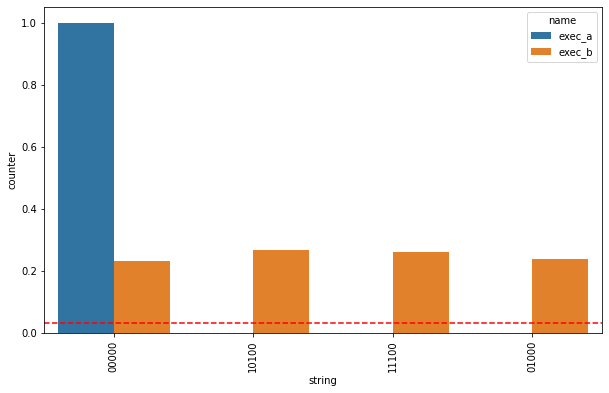

In [99]:
OneNightStandInspector(
    counts_source,
    counts_follow,
    top_perc=1
)

## BUG: Unable to map basis
qmt_v20 b40e833017b34b30a0789a89d385acb4

In [88]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(RXGate(3.8405054437941035), qargs=[qr[3]], cargs=[])
qc.append(CZGate(), qargs=[qr[4], qr[2]], cargs=[])

qc.measure(qr, cr)

from qiskit import transpile
qc = transpile(qc, basis_gates=['cx', 'h', 's', 't'], optimization_level=0,
    coupling_map=None)

from qiskit import Aer, transpile, execute
backend_76c59141ed674846b38a2b3fcae19894 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_76c59141ed674846b38a2b3fcae19894, shots=979).result().get_counts(qc)
counts

{'00000': 979}

In [ ]:
gate_list = [
    
]
for 
sel.has_entry(HGate())

In [68]:
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel

In [76]:
sel.has_entry(HGate())

True

In [92]:
translations = sel.get_entry(RXGate(3.84))
for translation in translations:
    print(translation.__dict__)
    print(translation.draw(fold=-1))
    plt.show()

{'_base_name': 'circuit', 'name': 'circuit-12638', '_data': [(Instruction(name='r', num_qubits=1, num_clbits=0, params=[ParameterExpression(3.84), 0]), [Qubit(QuantumRegister(1, 'q'), 0)], [])], '_control_flow_scopes': [], 'qregs': [QuantumRegister(1, 'q')], 'cregs': [], '_qubits': [Qubit(QuantumRegister(1, 'q'), 0)], '_clbits': [], '_qubit_indices': {Qubit(QuantumRegister(1, 'q'), 0): BitLocations(index=0, registers=[(QuantumRegister(1, 'q'), 0)])}, '_clbit_indices': {}, '_ancillas': [], '_calibrations': defaultdict(<class 'dict'>, {}), '_parameter_table': ParameterTable({}), '_parameters': None, '_layout': None, '_global_phase': 0, 'duration': None, 'unit': 'dt', '_metadata': None}
   ┌───────────┐
q: ┤ R(3.84,0) ├
   └───────────┘


In [91]:

translations[0].draw(fold=-1)

┌───────────┐
q: ┤ R(3.84,0) ├
   └───────────┘

## BUG: unbound parameters in OpenQASM 2
qmt_v012 aa3634f97fc5476e955e39834c118c4a

In [77]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(ECRGate(), qargs=[qr[0], qr[1]], cargs=[])
qc.append(U1Gate(0.07645578313559849), qargs=[qr[1]], cargs=[])
qc.append(TdgGate(), qargs=[qr[0]], cargs=[])
qc.append(RYGate(3.036477369136538), qargs=[qr[1]], cargs=[])
qc.append(PhaseGate(4.881694463136383), qargs=[qr[0]], cargs=[])
qc.append(TGate(), qargs=[qr[0]], cargs=[])
qc.append(U1Gate(3.34149534835996), qargs=[qr[0]], cargs=[])
qc.append(RYGate(2.9059964560129927), qargs=[qr[0]], cargs=[])
qc.append(CRXGate(0.8276603226911154), qargs=[qr[0], qr[1]], cargs=[])
qc.append(CRYGate(2.7399976883191965), qargs=[qr[0], qr[1]], cargs=[])
qc.append(SGate(), qargs=[qr[0]], cargs=[])
qc.append(U2Gate(5.51426247474029,4.431230633161206), qargs=[qr[0]], cargs=[])
qc.append(PhaseGate(5.579138926544036), qargs=[qr[1]], cargs=[])
qc.append(U2Gate(2.9809268493236627,5.692832719934384), qargs=[qr[1]], cargs=[])
qc.append(TdgGate(), qargs=[qr[0]], cargs=[])
qc.append(RZXGate(5.440882692563118), qargs=[qr[1], qr[0]], cargs=[])
qc.append(TGate(), qargs=[qr[0]], cargs=[])
qc.append(RZXGate(4.102748932572386), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RXXGate(3.9470867646141365), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RXXGate(0.27083605847020614), qargs=[qr[0], qr[1]], cargs=[])
qc.append(CRYGate(3.807733373401569), qargs=[qr[0], qr[1]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[1]], cargs=[])
qc.append(RYYGate(4.825870225220896), qargs=[qr[1], qr[0]], cargs=[])
qc.append(U1Gate(1.5784443320231467), qargs=[qr[1]], cargs=[])
qc.append(PhaseGate(2.2737520228785515), qargs=[qr[0]], cargs=[])
qc.append(RYYGate(1.812059626450451), qargs=[qr[0], qr[1]], cargs=[])
qc.append(CRXGate(0.31035100835548557), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RYGate(3.457953448141083), qargs=[qr[1]], cargs=[])
qc.append(YGate(), qargs=[qr[1]], cargs=[])
qc.append(U2Gate(2.7361237883075282,1.8170983771036788), qargs=[qr[0]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_9dfa7d2cf13f470885b5372da0461040 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_9dfa7d2cf13f470885b5372da0461040, shots=346).result().get_counts(qc)
counts

{'11': 24, '01': 14, '10': 175, '00': 133}

In [ ]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: PARAMETERS
# SECTION
# NAME: PARAMETERS
p_5b93df = Parameter('p_5b93df')
p_1d20b7 = Parameter('p_1d20b7')
p_fc413b = Parameter('p_fc413b')
p_b0ec2b = Parameter('p_b0ec2b')
p_042185 = Parameter('p_042185')
p_b5cc79 = Parameter('p_b5cc79')
p_c2ee43 = Parameter('p_c2ee43')
p_9bb5e6 = Parameter('p_9bb5e6')
p_4e8d48 = Parameter('p_4e8d48')
p_16ecb1 = Parameter('p_16ecb1')
p_c1df96 = Parameter('p_c1df96')
p_bf0465 = Parameter('p_bf0465')
p_04081f = Parameter('p_04081f')
p_767666 = Parameter('p_767666')
p_51a4ea = Parameter('p_51a4ea')
p_a0c77c = Parameter('p_a0c77c')
p_12ac14 = Parameter('p_12ac14')
p_8c7f7e = Parameter('p_8c7f7e')
p_d001fe = Parameter('p_d001fe')
p_e6306b = Parameter('p_e6306b')
p_9cd839 = Parameter('p_9cd839')
p_c1f6cf = Parameter('p_c1f6cf')
p_766c0e = Parameter('p_766c0e')
p_cc4e69 = Parameter('p_cc4e69')

# SECTION
# NAME: CIRCUIT
qr = QuantumRegister(2, name='qr')
cr = ClassicalRegister(2, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(ECRGate(), qargs=[qr[0], qr[1]], cargs=[])
subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(SwapGate(), qargs=[qr[0], qr[1]], cargs=[])
subcircuit.append(CUGate(p_12ac14, p_04081f, p_fc413b, p_c2ee43), qargs=[qr
    [0], qr[1]], cargs=[])
subcircuit.append(CU1Gate(p_9cd839), qargs=[qr[0], qr[1]], cargs=[])
subcircuit.append(SXdgGate(), qargs=[qr[0]], cargs=[])
subcircuit.append(DCXGate(), qargs=[qr[1], qr[0]], cargs=[])
subcircuit.append(SXGate(), qargs=[qr[1]], cargs=[])
subcircuit.append(XGate(), qargs=[qr[0]], cargs=[])
subcircuit.append(CYGate(), qargs=[qr[0], qr[1]], cargs=[])
subcircuit.append(U2Gate(4.123949183532893, p_51a4ea), qargs=[qr[1]], cargs=[])
qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
qc.append(U1Gate(0.07645578313559849), qargs=[qr[1]], cargs=[])
qc.append(TdgGate(), qargs=[qr[0]], cargs=[])
qc.append(RYGate(3.036477369136538), qargs=[qr[1]], cargs=[])
qc.append(PhaseGate(p_a0c77c), qargs=[qr[0]], cargs=[])
qc.append(TGate(), qargs=[qr[0]], cargs=[])
qc.append(U1Gate(p_d001fe), qargs=[qr[0]], cargs=[])
qc.append(RYGate(p_e6306b), qargs=[qr[0]], cargs=[])
qc.append(CRXGate(p_cc4e69), qargs=[qr[0], qr[1]], cargs=[])
qc.append(CRYGate(p_767666), qargs=[qr[0], qr[1]], cargs=[])
qc.append(SGate(), qargs=[qr[0]], cargs=[])
qc.append(U2Gate(p_1d20b7, 4.431230633161206), qargs=[qr[0]], cargs=[])
qc.append(PhaseGate(5.579138926544036), qargs=[qr[1]], cargs=[])
qc.append(U2Gate(2.9809268493236627, p_9bb5e6), qargs=[qr[1]], cargs=[])
qc.append(TdgGate(), qargs=[qr[0]], cargs=[])
qc.append(RZXGate(p_042185), qargs=[qr[1], qr[0]], cargs=[])
qc.append(TGate(), qargs=[qr[0]], cargs=[])
qc.append(RZXGate(p_c1df96), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RXXGate(p_bf0465), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RXXGate(p_4e8d48), qargs=[qr[0], qr[1]], cargs=[])
qc.append(CRYGate(p_16ecb1), qargs=[qr[0], qr[1]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[1]], cargs=[])
qc.append(RYYGate(p_b5cc79), qargs=[qr[1], qr[0]], cargs=[])
qc.append(U1Gate(p_766c0e), qargs=[qr[1]], cargs=[])
qc.append(PhaseGate(p_b0ec2b), qargs=[qr[0]], cargs=[])
qc.append(RYYGate(p_c1f6cf), qargs=[qr[0], qr[1]], cargs=[])
qc.append(CRXGate(0.31035100835548557), qargs=[qr[1], qr[0]], cargs=[])
qc.append(RYGate(p_8c7f7e), qargs=[qr[1]], cargs=[])
qc.append(YGate(), qargs=[qr[1]], cargs=[])
qc.append(U2Gate(2.7361237883075282, p_5b93df), qargs=[qr[0]], cargs=[])
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: PARAMETER_BINDING

qc = qc.bind_parameters({
    p_5b93df: 1.8170983771036788,
    p_1d20b7: 5.51426247474029,
    p_fc413b: 2.729865756857763,
    p_b0ec2b: 2.2737520228785515,
    p_042185: 5.440882692563118,
    p_b5cc79: 4.825870225220896,
    p_c2ee43: 0.784436739945248,
    p_9bb5e6: 5.692832719934384,
    p_4e8d48: 0.27083605847020614,
    p_16ecb1: 3.807733373401569,
    p_c1df96: 4.102748932572386,
    p_bf0465: 3.9470867646141365,
    p_04081f: 5.504184863632683,
    p_767666: 2.7399976883191965,
    p_51a4ea: 1.3529648929774023,
    p_a0c77c: 4.881694463136383,
    p_12ac14: 4.994905170986848,
    p_8c7f7e: 3.457953448141083,
    p_d001fe: 3.34149534835996,
    p_e6306b: 2.9059964560129927,
    p_9cd839: 0.384360237211019,
    p_c1f6cf: 1.812059626450451,
    p_766c0e: 1.5784443320231467,
    p_cc4e69: 0.8276603226911154,
})

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=['rx', 'ry', 'rz', 'p', 'cx'], optimization_level=0, coupling_map=None)
# SECTION
# NAME: QASM_CONVERSION

qc = QuantumCircuit.from_qasm_str(qc.qasm())
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_9dfa7d2cf13f470885b5372da0461040 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_9dfa7d2cf13f470885b5372da0461040, shots=346).result().get_counts(qc)
RESULT = counts

# BUG: cannot find unitary
qmt_v20 af1312f9be1d43b89be72bce2a2d727c

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit import transpile
qr = QuantumRegister(3, name='qr')
cr = ClassicalRegister(3, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
subcircuit = QuantumCircuit(qr, name='subcircuit')
subcircuit.append(CSwapGate(), qargs=[qr[1], qr[0], qr[2]])
subcircuit.append(DCXGate(), qargs=[qr[0], qr[1]])
qc.append(subcircuit, qargs=qr)
qc.append(subcircuit.inverse(), qargs=qr)
qc.measure(qr, cr)
qc = transpile(qc, optimization_level=3)
qc.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
gate unitary140323758184192 p0,p1 {
	u3(pi/2,pi/2,-pi/2) p0;
	u3(pi/2,0,3*pi/4) p1;
	cx p0,p1;
	u3(pi/2,-pi/2,pi/2) p0;
	u3(pi/4,pi/4,-pi/2) p1;
}
gate dcx q0,q1 { cx q0,q1; cx q1,q0; }
gate dcx_dg q0,q1 { cx q1,q0; cx q0,q1; }
qreg qr[3];
creg cr[3];
unitary140323758184192 qr[0],qr[2];
cx qr[1],qr[2];
t qr[2];
cx qr[0],qr[2];
t qr[0];
tdg qr[2];
cx qr[1],qr[2];
cx qr[1],qr[0];
tdg qr[0];
t qr[1];
cx qr[1],qr[0];
t qr[2];
h qr[2];
cx qr[2],qr[0];
dcx qr[0],qr[1];
dcx_dg qr[0],qr[1];
unitary140323758240288 qr[0],qr[2];
cx qr[1],qr[2];
t qr[2];
cx qr[0],qr[2];
t qr[0];
tdg qr[2];
cx qr[1],qr[2];
cx qr[1],qr[0];
tdg qr[0];
t qr[1];
cx qr[1],qr[0];
t qr[2];
h qr[2];
cx qr[2],qr[0];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];



In [2]:
try:
    qc = QuantumCircuit.from_qasm_str(qc.qasm())
except Exception as e:
    print(e)

"Cannot find gate definition for 'unitary140323758240288', line 30 file "


## BUG: cannot find gate definition rcccx
qmt_v19 655459b586434ec4b4e2d82f9d6b7abd

In [111]:
#SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(11, name='qr')
cr = ClassicalRegister(11, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(CHGate(), qargs=[qr[3], qr[1]], cargs=[])
qc.append(CU1Gate(3.001459306379496), qargs=[qr[10], qr[5]], cargs=[])
qc.append(CZGate(), qargs=[qr[10], qr[2]], cargs=[])
qc.append(U1Gate(6.168334007761457), qargs=[qr[7]], cargs=[])
qc.append(CHGate(), qargs=[qr[4], qr[7]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[6]], cargs=[])
qc.append(SwapGate(), qargs=[qr[10], qr[6]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[6], qr[5], qr[8]], cargs=[])
qc.append(RC3XGate(), qargs=[qr[8], qr[7], qr[9], qr[4]], cargs=[])
qc.append(CHGate(), qargs=[qr[6], qr[8]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[4], qr[2], qr[5]], cargs=[])
qc.append(RXXGate(3.717624460789032), qargs=[qr[9], qr[2]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[5]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[10]], cargs=[])
qc.append(PhaseGate(2.9363663072501205), qargs=[qr[8]], cargs=[])
qc.append(CHGate(), qargs=[qr[8], qr[10]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[7]], cargs=[])
qc.append(RC3XGate(), qargs=[qr[2], qr[8], qr[10], qr[1]], cargs=[])
qc.append(U1Gate(3.392515329500051), qargs=[qr[0]], cargs=[])
qc.append(RCCXGate(), qargs=[qr[8], qr[7], qr[6]], cargs=[])
qc.append(PhaseGate(3.491399104775617), qargs=[qr[4]], cargs=[])
qc.append(RXXGate(0.7638624774750333), qargs=[qr[10], qr[1]], cargs=[])
qc.append(RZGate(5.708541902391605), qargs=[qr[10]], cargs=[])
qc.append(RYYGate(3.955007888884436), qargs=[qr[3], qr[5]], cargs=[])
qc.append(UGate(0.7492203571871445,1.5804353903693034,0.4083158171844422), qargs=[qr[9]], cargs=[])
qc.append(CRYGate(0.0059405938354801565), qargs=[qr[10], qr[0]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_8b530f83bade4c33b9ef3e11942d73d7 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_8b530f83bade4c33b9ef3e11942d73d7, shots=7838).result().get_counts(qc)
counts

{'01000100010': 1,
 '01000001010': 4,
 '10000001000': 208,
 '11000100000': 4,
 '01000101110': 397,
 '00000100110': 17,
 '01000101010': 6,
 '01000000110': 81,
 '11000000100': 416,
 '10000101000': 202,
 '01000001110': 357,
 '10000001100': 340,
 '11000100100': 434,
 '10000101100': 371,
 '10000000000': 39,
 '00000101010': 28,
 '11000101100': 2233,
 '00000000110': 13,
 '11000101000': 25,
 '11000001100': 2215,
 '01000000010': 2,
 '00000001010': 36,
 '00000101110': 64,
 '11000000000': 4,
 '01000100110': 71,
 '10000100000': 43,
 '11000001000': 31,
 '00000100010': 8,
 '10000000100': 73,
 '10000100100': 51,
 '00000001110': 59,
 '00000000010': 5}

In [60]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(RC3XGate(), qargs=[qr[0], qr[1], qr[2], qr[3]], cargs=[])
subcircuit = QuantumCircuit(qr, name='subcircuit')
subcircuit.append(C4XGate(), qargs=[qr[0], qr[1], qr[2], qr[3], qr[4]])
qc.append(subcircuit, qargs=qr)
qc.measure(qr, cr)
qc.qasm(formatted=True)

OPENQASM 2.0;
include "qelib1.inc";
gate rcccx_dg q0,q1,q2,q3 { u2(-2*pi,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(-2*pi,pi) q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; cx q0,q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; cx q0,q3; u2(-2*pi,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(-2*pi,pi) q3; }
gate rcccx q0,q1,q2,q3 { u2(0,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(0,pi) q3; cx q0,q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; cx q0,q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; u2(0,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(0,pi) q3; }
gate mcx q0,q1,q2,q3,q4 { h q4; cu1(pi/2) q3,q4; h q4; rcccx q0,q1,q2,q3; h q4; cu1(-pi/2) q3,q4; h q4; rcccx_dg q0,q1,q2,q3; c3sx q0,q1,q2,q4; }
gate subcircuit q0,q1,q2,q3,q4 { mcx q0,q1,q2,q3,q4; }
qreg qr[5];
creg cr[5];
subcircuit qr[0],qr[1],qr[2],qr[3],qr[4];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];
measure qr[3] -> cr[3];
measure qr[4] -> cr[4];



In [61]:
try:
    qc = QuantumCircuit.from_qasm_str(qc.qasm())
except Exception as e:
    print(e)

"Cannot find gate definition for 'c3sx', line 5 file "


In [53]:
qc = QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";
gate rcccx_dg q0,q1,q2,q3 { u2(-2*pi,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(-2*pi,pi) q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; cx q0,q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; cx q0,q3; u2(-2*pi,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(-2*pi,pi) q3; }
gate rcccx q0,q1,q2,q3 { u2(0,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(0,pi) q3; cx q0,q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; cx q0,q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; u2(0,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(0,pi) q3; }
gate mcx q0,q1,q2,q3,q4 { h q4; cu1(pi/2) q3,q4; h q4; rcccx q0,q1,q2,q3; h q4; cu1(-pi/2) q3,q4; h q4; rcccx_dg q0,q1,q2,q3; c3sqrtx q0,q1,q2,q4; }
gate subcircuit q0,q1,q2,q3,q4 { mcx q0,q1,q2,q3,q4; }
qreg qr[5];
creg cr[5];
creg meas[5];
rcccx qr[0],qr[1],qr[2],qr[3];
subcircuit qr[0],qr[1],qr[2],qr[3],qr[4];
barrier qr[0],qr[1],qr[2],qr[3],qr[4];
measure qr[0] -> meas[0];
measure qr[1] -> meas[1];
measure qr[2] -> meas[2];
measure qr[3] -> meas[3];
measure qr[4] -> meas[4];
""")
backend_8b530f83bade4c33b9ef3e11942d73d7 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_8b530f83bade4c33b9ef3e11942d73d7, shots=7838).result().get_counts(qc)
counts

{'00000 00000': 7838}

## BUG: divergence (FALSE ALARM)

qmt_v10 89bad7df42a249338af9305279a787e6 (maybe the output distribution is quite spread out with 0.08 for the most frequent bitstring)

qmt_v10 093c99a93ac04293b914cd743dec566c ("run independent" but we do not have mapping to the the relationship again, impossible to debug)

qmt_v10 002dbe13188e4250807378ca5507d941 (it seemed only an unlucky run)

qmt_v10 bc54955c63ad4674ba235a9ee8a67b80 (it seemed only an unlucky run = not super low pval and not reproducible)

qmt_v11 00550a4609da44d5afdbe4124ff184ef (pval = 0.029) (it seemed only an unlucky run, rerunning it is more difficult because it had the scrumbled qubit order)

qmt_v07 2a5aba61a72c43ed98493445abcee777 (measure after transpile, aka sort of improper API usage). Note: use more recent experiment version to ensure that the generated program do no use the circuit after transpilation)

qmt_v07 01fdce9c35494bf594c53877f8490d79 (0.000255 derived from a crash because the default result gives a dictionary with {"0": 0}) Note: use the recent versions so that we have a separate crash database to rule out this cases

qmt_v08 d77cc111a1a749418597c11bf6247a56 (measure after transpile, aka sort of improper API usage) Note: use more recent experiment version.

qmt_v10 89bad7df42a249338af9305279a787e6 (divergent with small shots, but increasing the shots (x8) the divergence disappeared) Note: maybe increase the constant in front of the estimation of number of shots.

qmt_v12 facbe4f34bd540d78f311cd76099dfab ("run independent" but we do not have mapping to the the relationship again, impossible to debug) * MANY OTHER LIKE THIS. Note: maybe artificially increasing the samples leads to an unfair amount of difference, since the artifical sample will have larger sample size in view of the statitical test.

In [23]:
PVAL_COL = "divergence.ks.p-value"
PROGRAM_ID

'bef8386c5f7346eba1df9def780bb84e'

In [24]:
inspec_column_of(
    df=df_data,
    program_id=PROGRAM_ID,
    target_col=PVAL_COL    
)

n hits: 1
0.0


In [25]:
# SOURCE

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter

# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(11, name='qr')
cr = ClassicalRegister(11, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(DCXGate(), qargs=[qr[6], qr[1]], cargs=[])
qc.append(CRZGate(3.3071758639390256), qargs=[qr[10], qr[3]], cargs=[])
qc.append(IGate(), qargs=[qr[1]], cargs=[])
qc.append(CRXGate(0.7825420770749135), qargs=[qr[6], qr[1]], cargs=[])
qc.append(CSwapGate(), qargs=[qr[7], qr[6], qr[4]], cargs=[])
qc.append(CHGate(), qargs=[qr[3], qr[4]], cargs=[])
qc.append(RZGate(0.7035008074921808), qargs=[qr[1]], cargs=[])
qc.append(CCXGate(), qargs=[qr[5], qr[10], qr[1]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[8]], cargs=[])
qc.append(XGate(), qargs=[qr[0]], cargs=[])
qc.append(DCXGate(), qargs=[qr[1], qr[8]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[2]], cargs=[])

# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=2, coupling_map=None)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_ffc4669f2a2140d49669edd62a7ff1d5 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_ffc4669f2a2140d49669edd62a7ff1d5, shots=7838).result().get_counts(qc)
counts

{'00000000001': 3850, '00100000011': 3988}

In [28]:
#--------------------------------------------------------------------------------
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: PARAMETERS

p_34a7ee = Parameter('p_34a7ee')
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(11, name='qr')
cr = ClassicalRegister(11, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
qc.append(IGate(), qargs=[qr[2]], cargs=[])
qc.append(DCXGate(), qargs=[qr[6], qr[1]], cargs=[])
qc.append(CRZGate(3.3071758639390256), qargs=[qr[10], qr[3]], cargs=[])
qc.append(IGate(), qargs=[qr[1]], cargs=[])
qc.append(CRXGate(0.7825420770749135), qargs=[qr[6], qr[1]], cargs=[])
qc.append(CSwapGate(), qargs=[qr[7], qr[6], qr[4]], cargs=[])
qc.append(CHGate(), qargs=[qr[3], qr[4]], cargs=[])
qc.append(RZGate(p_34a7ee), qargs=[qr[1]], cargs=[])
qc.append(CCXGate(), qargs=[qr[5], qr[10], qr[1]], cargs=[])
qc.append(SXdgGate(), qargs=[qr[8]], cargs=[])
qc.append(XGate(), qargs=[qr[0]], cargs=[])
qc.append(DCXGate(), qargs=[qr[1], qr[8]], cargs=[])
qc.append(SwapGate(), qargs=[qr[6], qr[2]], cargs=[])
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: PARAMETER_BINDING

qc = qc.bind_parameters({p_34a7ee: 0.7035008074921808})
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=None)
# SECTION
# NAME: QASM_CONVERSION
qc = QuantumCircuit.from_qasm_str(qc.qasm())
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_ffc4669f2a2140d49669edd62a7ff1d5 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_ffc4669f2a2140d49669edd62a7ff1d5, shots=7838).result().get_counts(qc)
counts

{'00000010101': 1014,
 '00100000011': 987,
 '00100000111': 976,
 '00000000001': 963,
 '00100010111': 995,
 '00100010011': 922,
 '00000000101': 947,
 '00000010001': 1034}

In [79]:
# FOLLOWUP
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit import Parameter
# SECTION
# NAME: CIRCUIT

qr = QuantumRegister(5, name='qr')
cr = ClassicalRegister(5, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')


subcircuit = QuantumCircuit(qr, cr, name='subcircuit')
subcircuit.append(CUGate(4.638295177215426,2.4816698430762214,3.735145493818512,5.552501004888056), qargs=[qr[0], qr[4]], cargs=[])
subcircuit.append(CXGate(), qargs=[qr[2], qr[4]], cargs=[])
subcircuit.append(CSwapGate(), qargs=[qr[0], qr[2], qr[3]], cargs=[])

qc.append(subcircuit, qargs=qr, cargs=cr)
qc.append(subcircuit.inverse(), qargs=qr, cargs=cr)
# SECTION
# NAME: MEASUREMENT

qc.measure(qr, cr)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, 
               optimization_level=3, 
               coupling_map=[[0, 1], [1, 0], [1, 3], [1, 4], [2, 3], [3, 1], [3, 2], [4, 1], [4, 6], [5, 6], [6, 4], [6, 5]], 
               seed_transpiler=44)
qc.draw(fold=-1)

┌───┐                                                   ┌───┐┌─────┐┌───┐                                                       ░ ┌─┐            
     qr_0 -> 0 ────────────────■────────────────────────────────────────────────────■─────────────────────■─────────────────■───┤ T ├───■───────────────X────────X───────────────X──────┤ X ├┤ Tdg ├┤ X ├─X────────────────────────────────■────────────────────░─┤M├────────────
               ┌───────────────┴────────────────┐┌───┐   ┌───┐                    ┌─┴─┐┌───┐┌───┐┌─────┐┌─┴─┐┌───┐┌───┐   ┌─┴─┐┌┴───┴┐┌─┴─┐┌──────────┐ │        │        ┌───┐  │      └─┬─┘└┬───┬┘└─┬─┘ │ ┌───┐        ┌─────────────────┴──────────────────┐ ░ └╥┘         ┌─┐
     qr_4 -> 1 ┤ U(4.6383,2.4817,3.7351,5.5525) ├┤ X ├─X─┤ X ├───────■──────────X─┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ H ├─X─┤ X ├┤ Tdg ├┤ X ├┤0         ├─X───■────X────■───┤ T ├──X───■────■───┤ T ├───■───X─┤ X ├──■───X─┤ U(-4.6383,-3.7351,-2.4817,-5.5525) ├─░──╫──────────┤M├
               └────────────────────────────────┘└─┬─┘ │ └─┬─┘       │          │ └───┘└───┘└─┬─┘└─────┘└───┘└───┘└───┘ │ └───┘└─────┘└───┘│          │     │         │   └───┘      │        └───┘         └─┬─┘  │   │ └────────────────────────────────────┘ ░  ║          └╥┘
ancilla_0 -> 2 ────────────────────────────────────┼───┼───┼─────────┼──────────┼─────────────┼─────────────────────────┼──────────────────┤          ├─────┼─────────┼──────────────┼────────────────────────┼────┼───┼────────────────────────────────────────░──╫───────────╫─
                                                   │   │   │         │          │             │                         │                  │  Unitary │     │         │              │                        │  ┌─┴─┐ │                                        ░  ║    ┌─┐    ║ 
     qr_2 -> 3 ────────────────────────────────────■───X───┼─────────┼──────────┼─────────────┼─────────────────────────┼──────────────────┤          ├─────┼─────────┼──────────────┼────────────────────────┼──┤ X ├─X────────────────────────────────────────░──╫────┤M├────╫─
                                                           │  ┌───┐┌─┴─┐┌─────┐ │             │   ┌───┐                 │                  │          │   ┌─┴─┐┌───┐┌─┴─┐┌─────┐   ┌─┴─┐┌───┐ ┌───┐           │  └───┘                                          ░  ║    └╥┘┌─┐ ║ 
     qr_3 -> 4 ────────────────────────────────────────────■──┤ H ├┤ X ├┤ Tdg ├─X─────────────■───┤ T ├─────────────────X──────────────────┤1         ├───┤ X ├┤ T ├┤ X ├┤ Tdg ├───┤ X ├┤ T ├─┤ H ├───────────■─────────────────────────────────────────────────░──╫─────╫─┤M├─╫─
                                                              └───┘└───┘└─────┘                   └───┘                                    └──────────┘   └───┘└───┘└───┘└─────┘   └───┘└───┘ └───┘                                                             ░  ║     ║ └╥┘ ║ 
ancilla_1 -> 5 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫─────╫──╫──╫─
                                                                                                                                                                                                                                                                ░  ║ ┌─┐ ║  ║  ║ 
     qr_1 -> 6 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫─┤M├─╫──╫──╫─
                                                                                                                                                                                                                                                                ░  ║ └╥┘ ║  ║  ║ 
         cr: 5/═══

In [80]:
# SECTION
# NAME: QASM_CONVERSION

qc = QuantumCircuit.from_qasm_str(qc.qasm())
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_04ca3b30d0b44cff8ee7c7aabe5dd837 = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_04ca3b30d0b44cff8ee7c7aabe5dd837, shots=979).result().get_counts(qc)
counts_follow

{'11100': 226, '01000': 250, '10100': 261, '00000': 242}

In [ ]:
b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/result/result.py:273

In [104]:
counts_source = counts_s
counts_follow = counts_f

In [81]:
detector = KS_Detector()
_, pval = detector.check(counts_source, counts_follow)
pval

1.3185091028807797e-271

n_qubits: 5
n_shots_platform_a: 979.0
n_shots_platform_b: 979.0
Uniform threshold: 0.03125


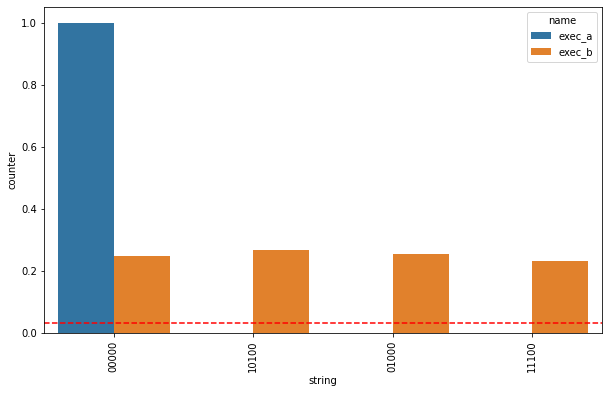

In [82]:
OneNightStandInspector(
    counts_source,
    counts_follow,
    top_perc=1
)